In [ ]:
!pip install git+https://github.com/fversaci/WaveTF.git

  Cloning https://github.com/fversaci/WaveTF.git to /tmp/pip-req-build-qyy3sq7v
  Running command git clone --filter=blob:none --quiet https://github.com/fversaci/WaveTF.git /tmp/pip-req-build-qyy3sq7v
  Resolved https://github.com/fversaci/WaveTF.git to commit e751efd0bd304e4671b385c80f23c49db314291f
  Preparing metadata (setup.py) ... done
  Created wheel for WaveTF: filename=WaveTF-0.1-py3-none-any.whl size=25264 sha256=199bc9668cf9d598fd841beb78bbe0f9d8305608fe35b31e1c443d88b0c801e0
  Stored in directory: /tmp/pip-ephem-wheel-cache-ia08o7r7/wheels/16/19/8e/8e274ec97352eba1749770c40d48672ef385993fdd5c47a735
Successfully built WaveTF


In [ ]:
!pip install pytest

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from keras.models import Sequential
from keras import activations
import wavetf
from wavetf._wavetf import WaveTFFactory

In [ ]:
import tensorflow as tf
from keras import layers

input_tensor = layers.Input(shape=(224, 224, 3))  # KerasTensor
print(type(input_tensor))  # <class 'keras.src.backend.common.keras_tensor.KerasTensor'>
print(type(input_tensor.shape.as_list()))  # TensorShape([None, 224, 224, 3])

# Pass KerasTensor to a custom layer or function that expects a tf.Tensor



<class 'keras.src.engine.keras_tensor.KerasTensor'>
<class 'list'>


In [ ]:

# Install specific Keras version (if not already installed)
!pip install keras==3.0.0
!pip install tensorflow==2.15
# Verify Keras version
import keras
print(keras.__version__)
import tensorflow as tf
from keras import models
from keras import layers
from keras.models import Sequential
from keras import activations
import wavetf
from wavetf._wavetf import WaveTFFactory
!pip install git+https://github.com/fversaci/WaveTF.git
!pip install pytest

  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 3.0.0
    Uninstalling keras-3.0.0:
      Successfully uninstalled keras-3.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.0 which is incompatible.
2.15.0
  Cloning https://github.com/fversaci/WaveTF.git to /tmp/pip-req-build-8qwd2fvx
  Running command git clone --filter=blob:none --quiet https://github.com/fversaci/WaveTF.git /tmp/pip-req-build-8qwd2fvx
  Resolved https://github.com/fversaci/WaveTF.git to commit e751efd0bd304e4671b385c80f23c49db314291f
  Preparing metadata (setup.py) ... done


In [ ]:
print(tf.__version__)
input_tensor = layers.Input(shape=(224, 224, 3))  # KerasTensor
print(type(input_tensor))  # <class 'keras.src.backend.common.keras_tensor.KerasTensor'>
print(type(input_tensor.shape.as_list()))  # TensorShape([None, 224, 224, 3])

# Pass KerasTensor to a custom layer or function that expects a tf.Tensor


2.15.0
<class 'keras.src.engine.keras_tensor.KerasTensor'>
<class 'list'>


In [ ]:
def down_block(x, filters, use_dwt = True):
    x = layers.Conv2D(filters, 3, padding= 'same',data_format="channels_last")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(filters, 3, padding= 'same',data_format="channels_last")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    if use_dwt == True:
        w = WaveTFFactory().build('haar', dim=2)

        t1 = w.call(x)
        (b,t,y,c) = tuple(t1.shape)
        ll = t1[:,:,:,:c//4]
        hf = t1[:,:,:,c//4:]
        return ll,hf,x
    else:
        return x
def up_block(x,y,hf, filters):
    x = layers.Concatenate(axis = -1)([x,hf])
    winv = WaveTFFactory().build('haar',dim=2,inverse = True)
    x=winv.call(x)
    x = layers.Concatenate(axis = -1)([x,y])
    x = layers.Conv2D(filters, 3, padding= 'same',data_format="channels_last")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(filters, 3, padding= 'same',data_format="channels_last")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    return x

def Unet(input_size = (256, 256, 1), *, classes, dropout):
    filters = [64,128,256,512, 1024]
    # encode
    input = layers.Input(shape = input_size)
    x,hf1, temp1 = down_block(input, filters[0])
    x,hf2, temp2 = down_block(x, filters[1])
    x,hf3, temp3 = down_block(x, filters[2])
    x,hf4, temp4 = down_block(x, filters[3])

    x = down_block(x, filters[4], use_dwt= False)
    # decode
    x = up_block(x, temp4,hf4, filters[3])
    x = up_block(x, temp3,hf3, filters[2])
    x = up_block(x, temp2,hf2, filters[1])
    x = up_block(x, temp1,hf1, filters[0])
    x = layers.Dropout(dropout)(x)
    output = layers.Conv2D(classes, 1, activation= 'softmax')(x)
    model = models.Model(input, output, name = 'unet')
    model.summary()
    return model

model = Unet((256,256,1), classes= 1, dropout= 0.2)
model.summary()



Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         640       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 64)         0         ['batch_normalization[0][0]

In [ ]:
import numpy as np
import logging
import nibabel as nib
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
def load_mri_image(file_path: str) -> np.ndarray:
        """
        Load MRI image from file.

        Args:
            file_path: Path to the .nii.gz file

        Returns:
            Loaded and squeezed MRI data
        """
        try:
            logger.info(f"Loading MRI image from: {file_path}")
            mri_img = nib.load(file_path)
            mri_data = mri_img.get_fdata()
            logger.info(f"Loaded MRI data shape: {mri_data.shape}")
            return mri_data.squeeze()
        except FileNotFoundError:
            logger.error(f"File not found: {file_path}")
            raise
        except Exception as e:
            logger.error(f"Error loading MRI file: {str(e)}")
            raise ValueError("Invalid file format or corrupted file")

[12/Nov/2024 22:20:06] INFO - Loading MRI image from: /content/IBSR_02_segTRI_ana.nii.gz
[12/Nov/2024 22:20:07] INFO - Loaded MRI data shape: (256, 128, 256, 1)


In [ ]:
print(data.shape)

(256, 128, 256)


In [ ]:
!pip install nibabel

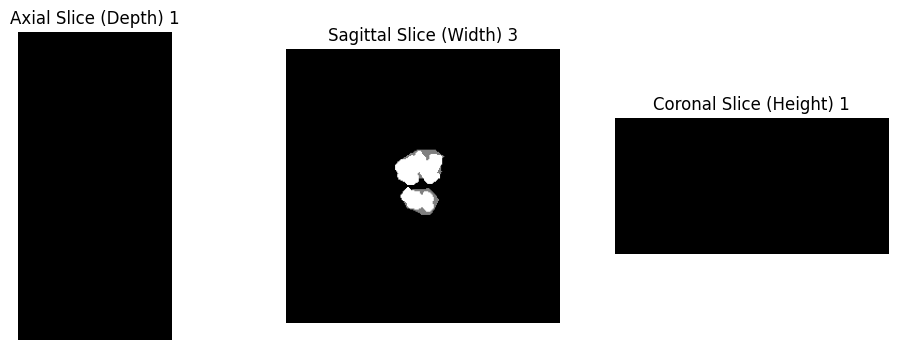

3


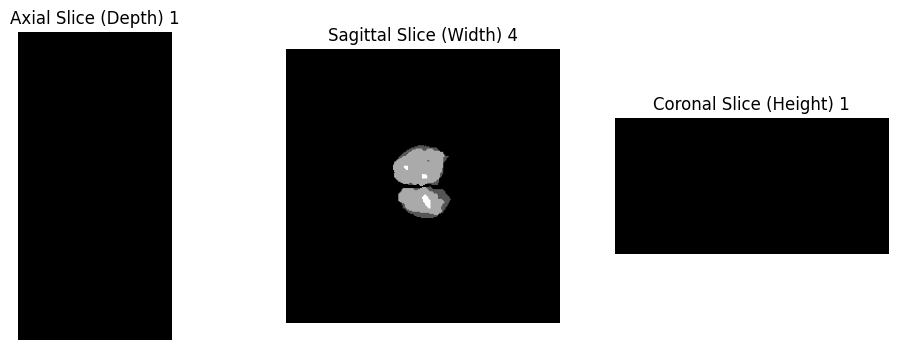

4


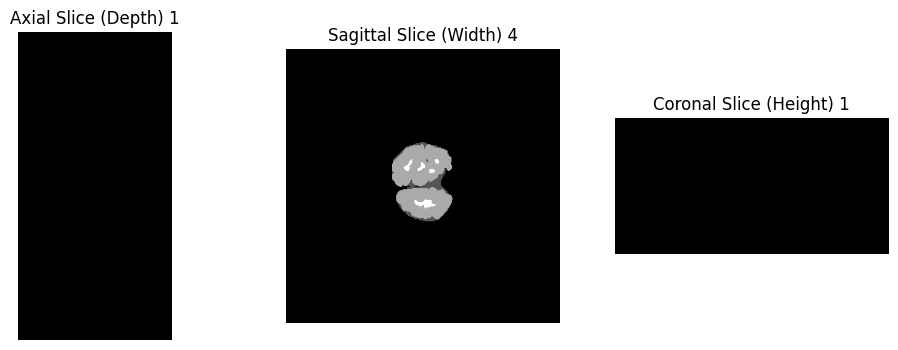

4


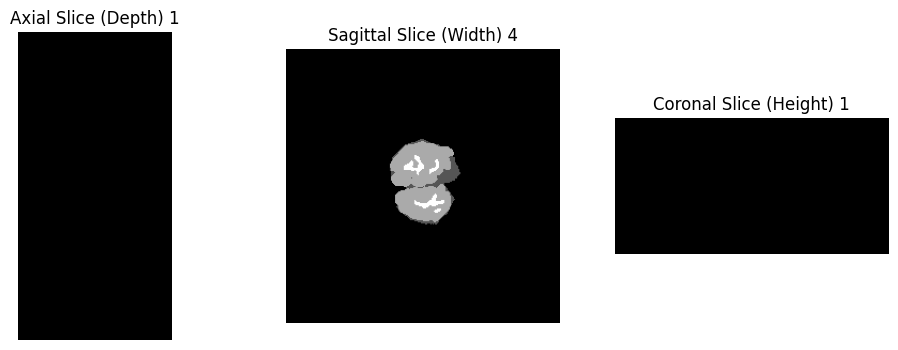

4


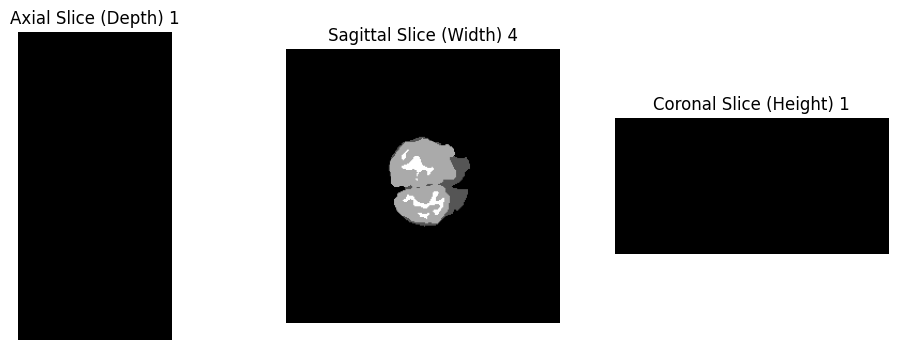

4


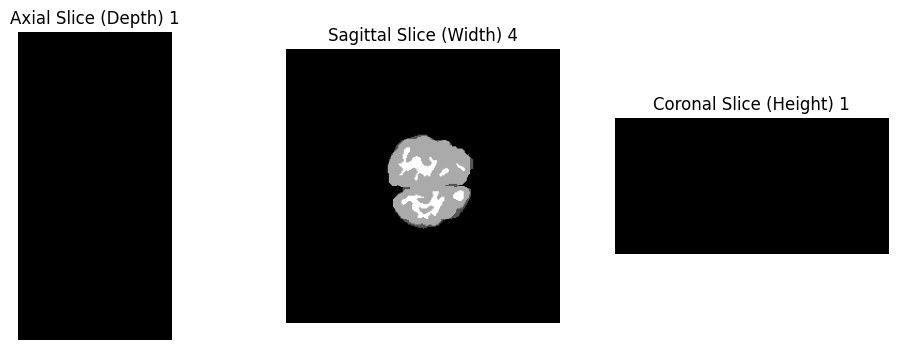

4


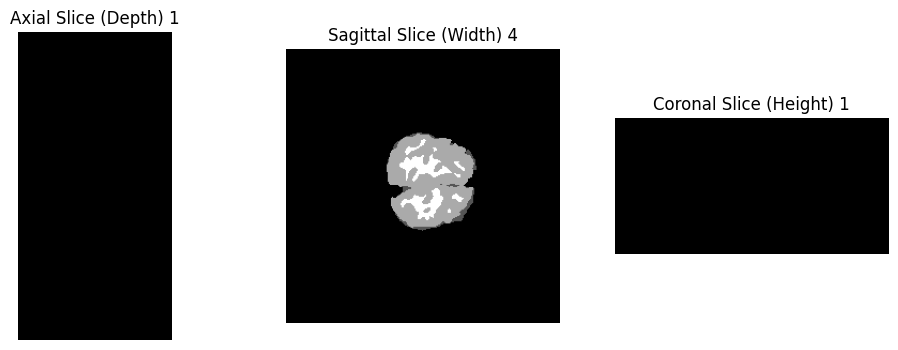

4


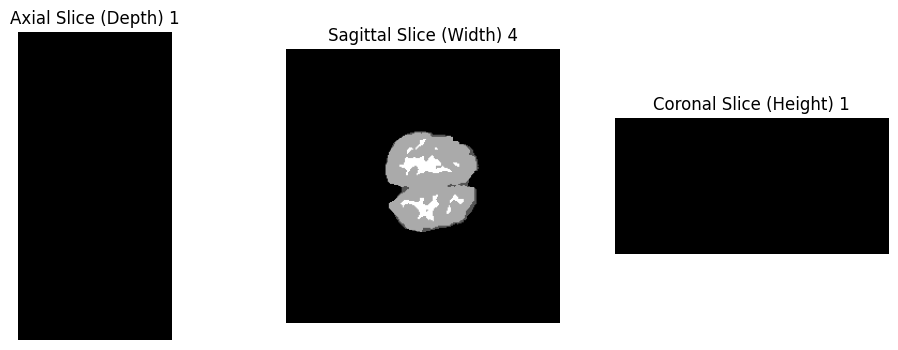

4


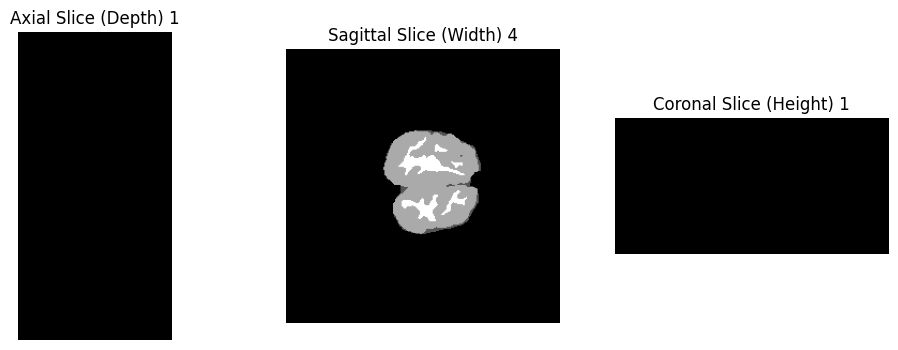

4


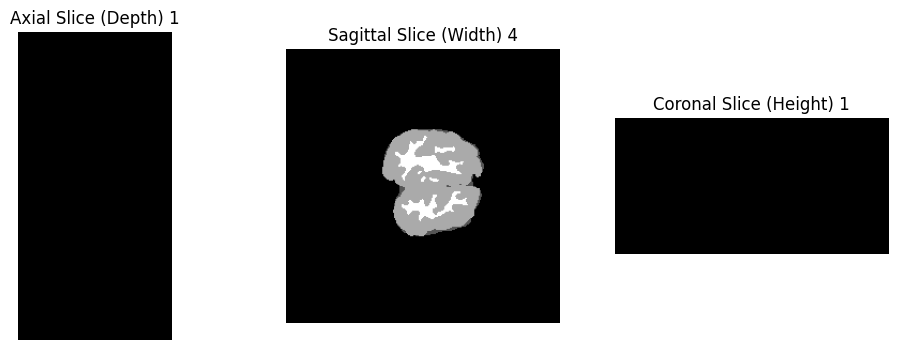

4


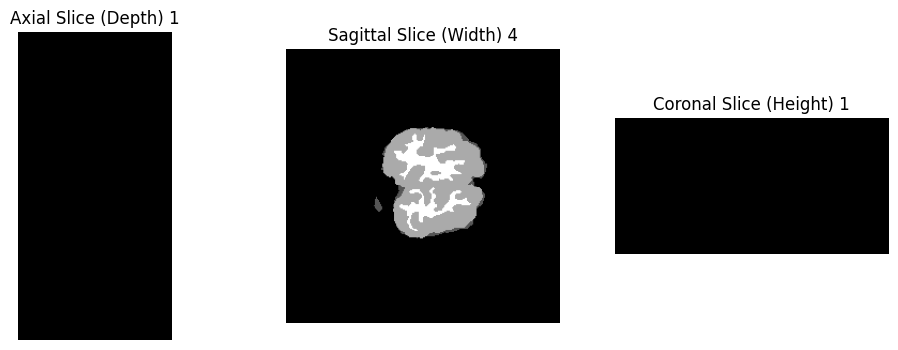

4


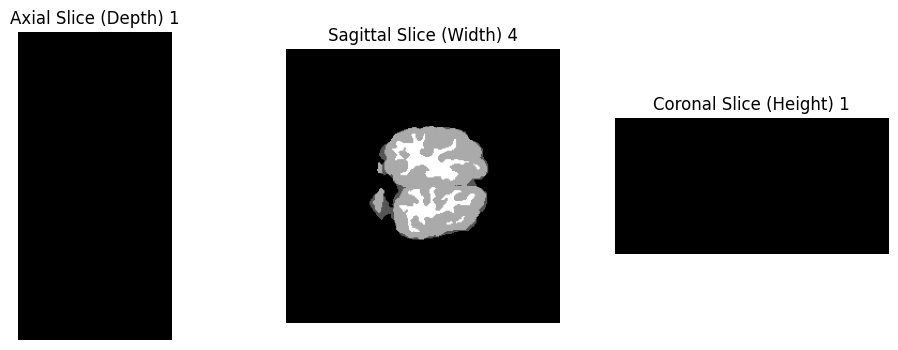

4


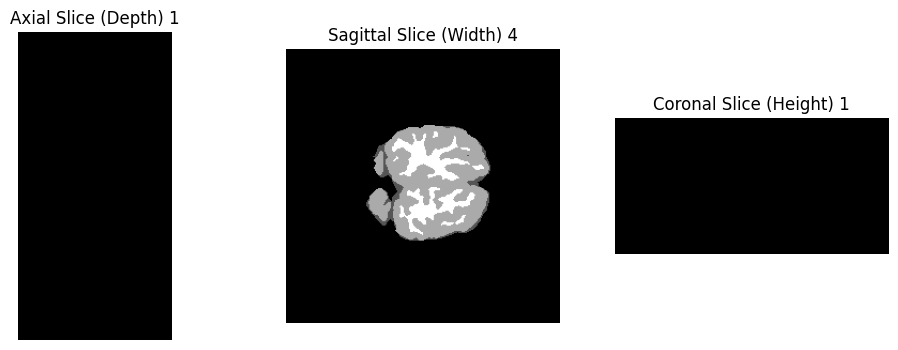

4


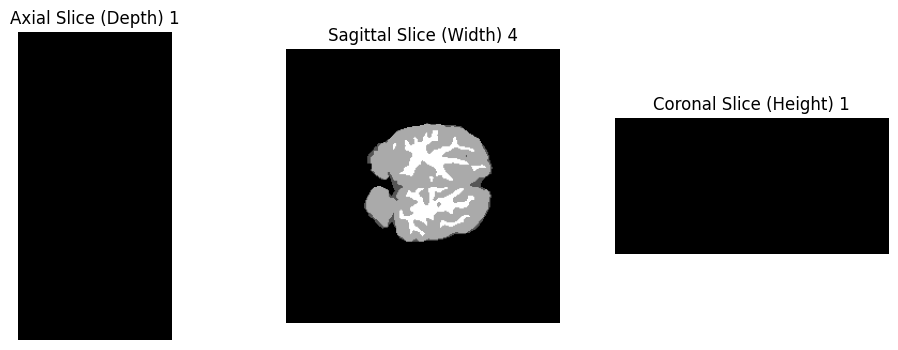

4


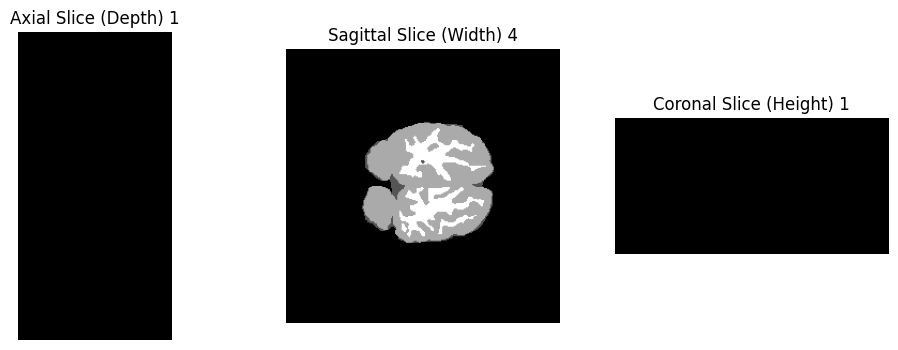

4


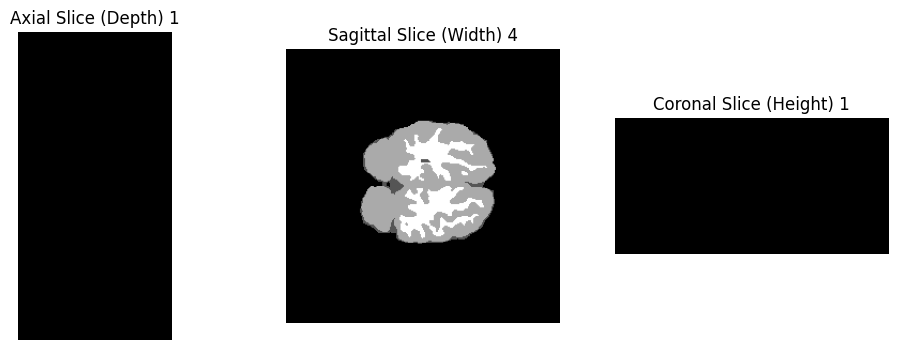

4


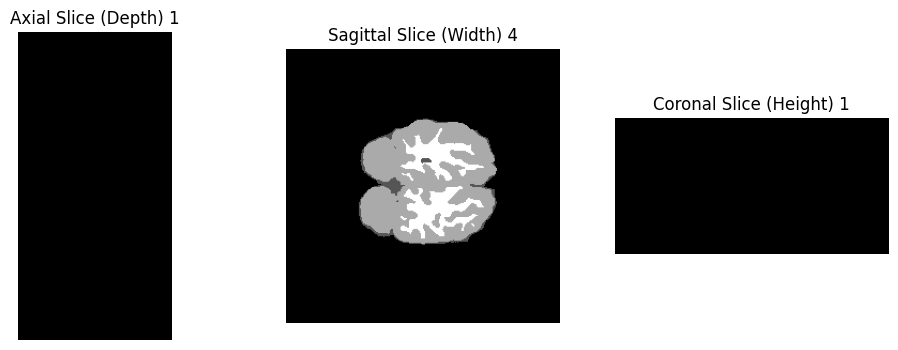

4


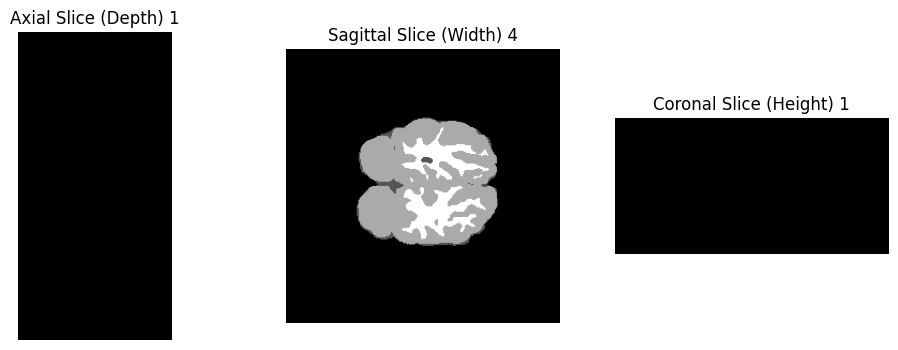

4


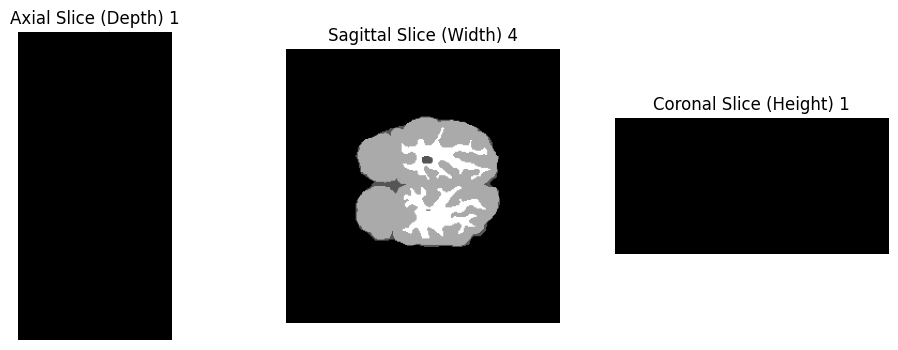

4


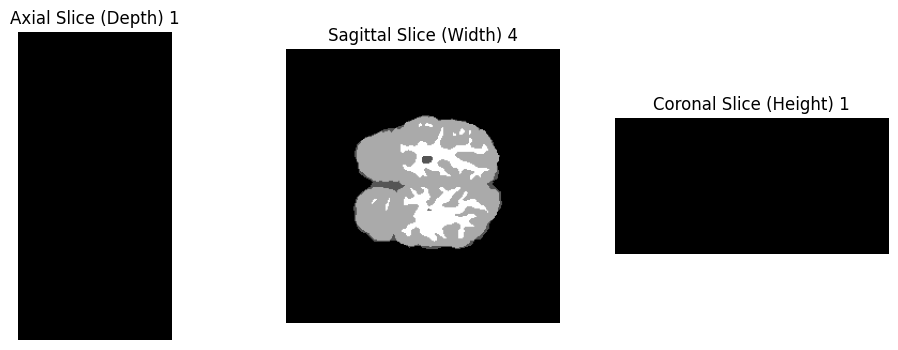

4


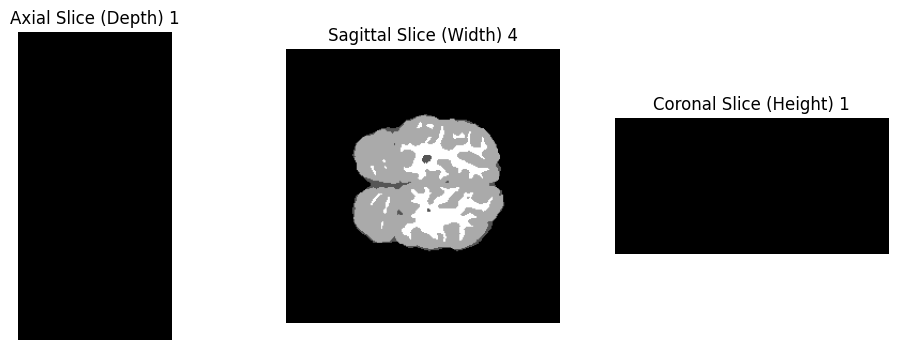

4


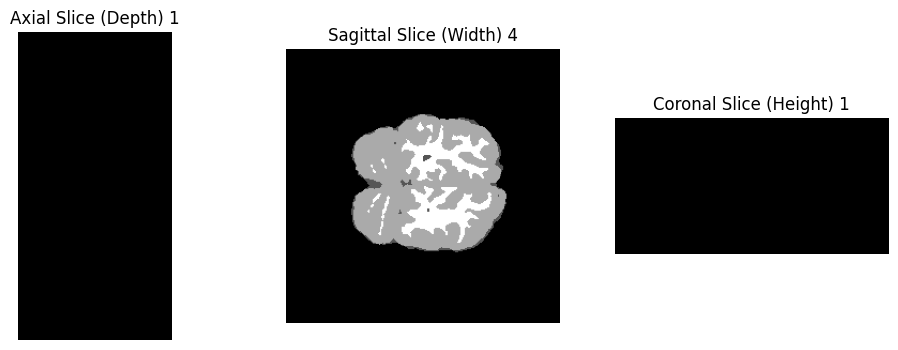

4


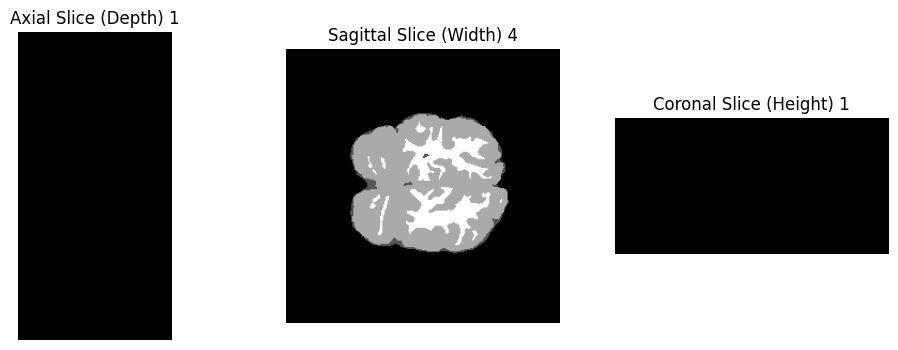

4


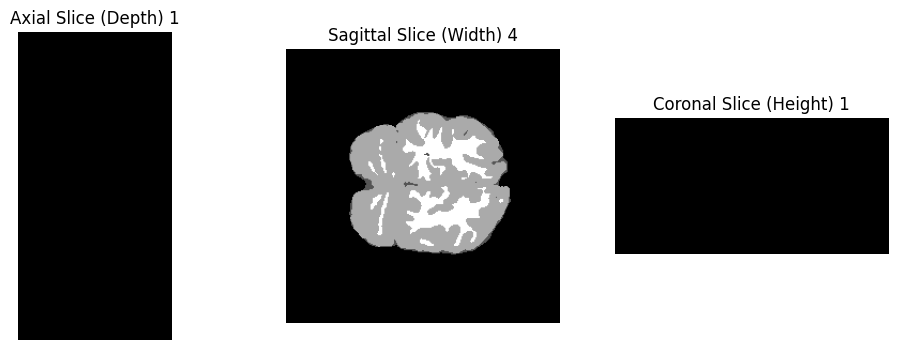

4


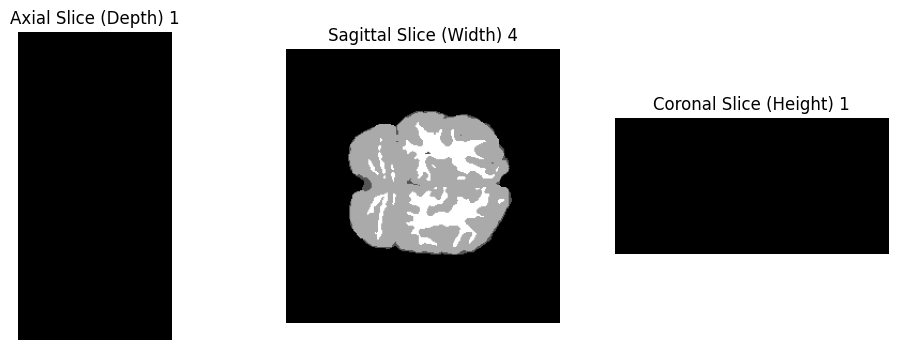

4


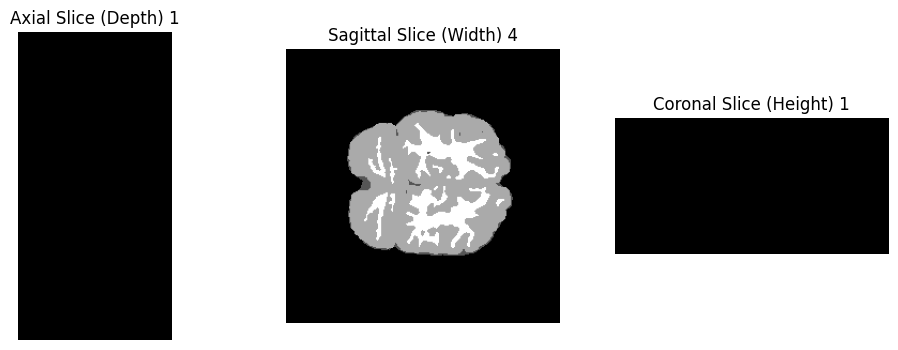

4


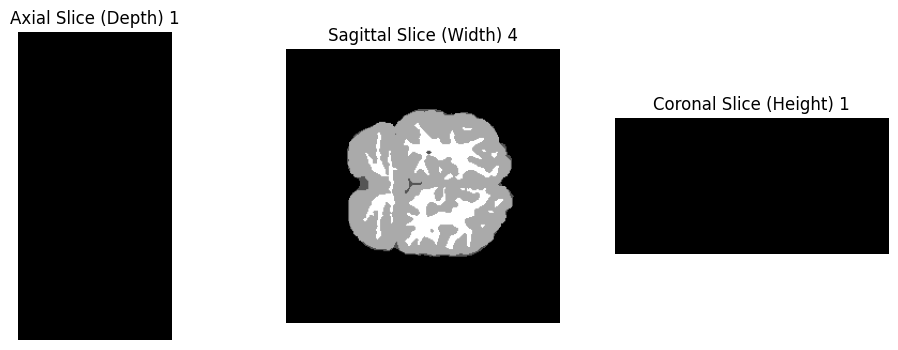

4


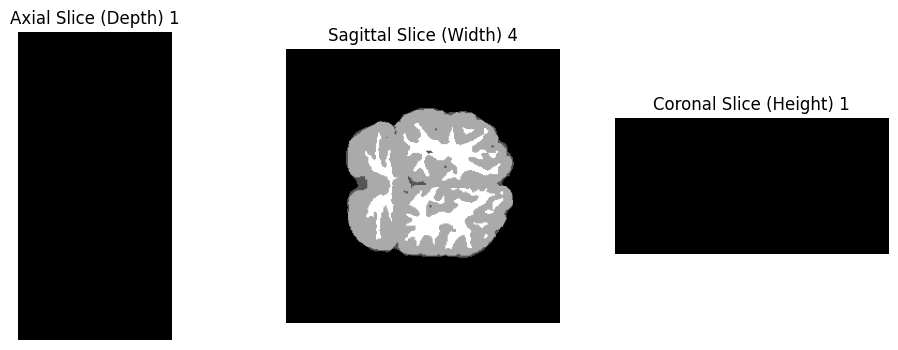

4


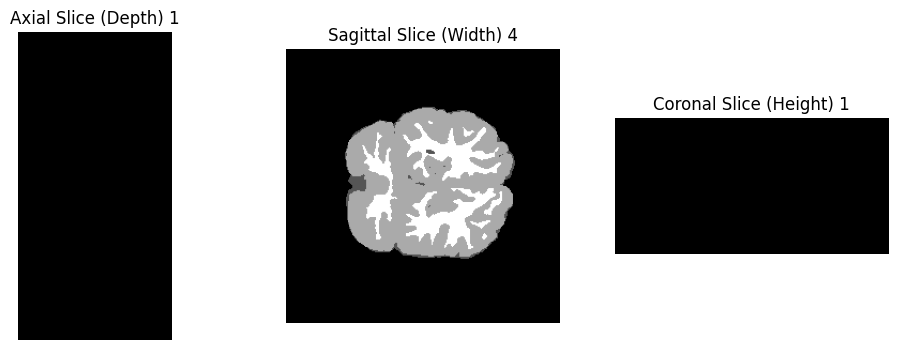

4


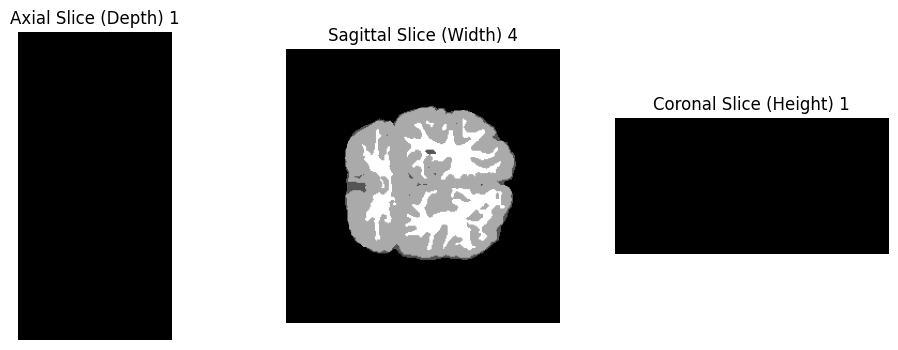

4


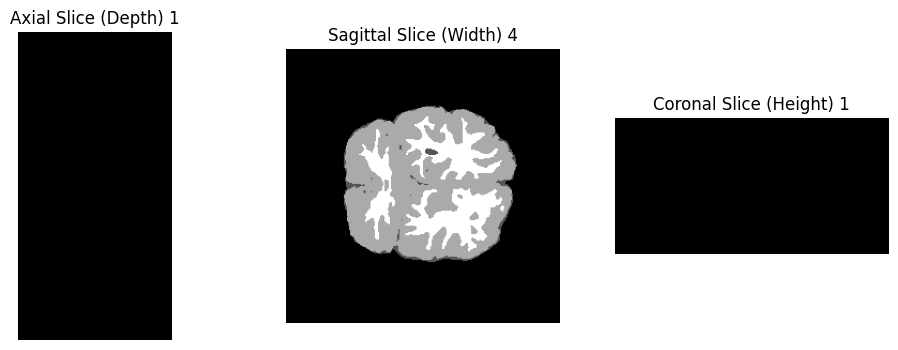

4


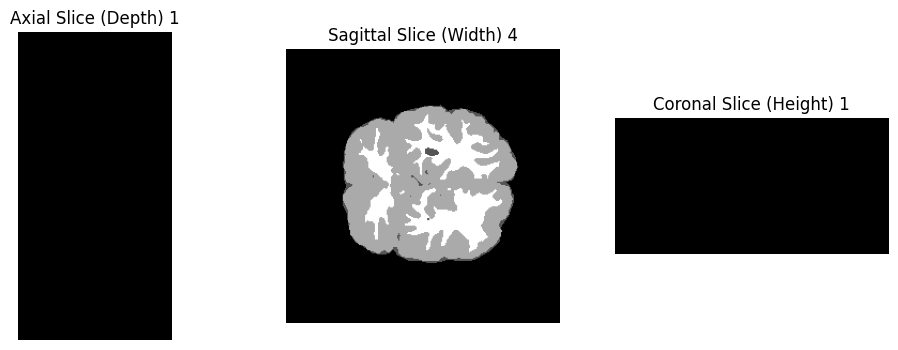

4


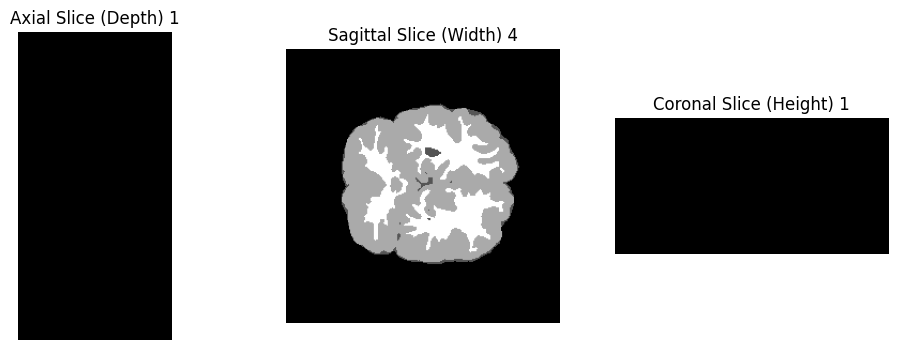

4


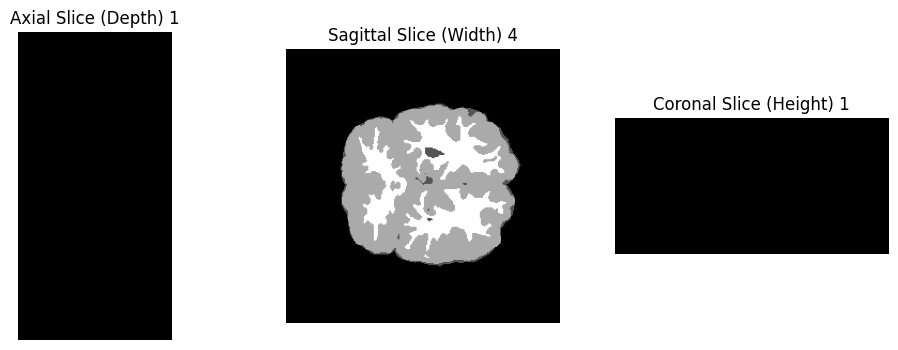

4


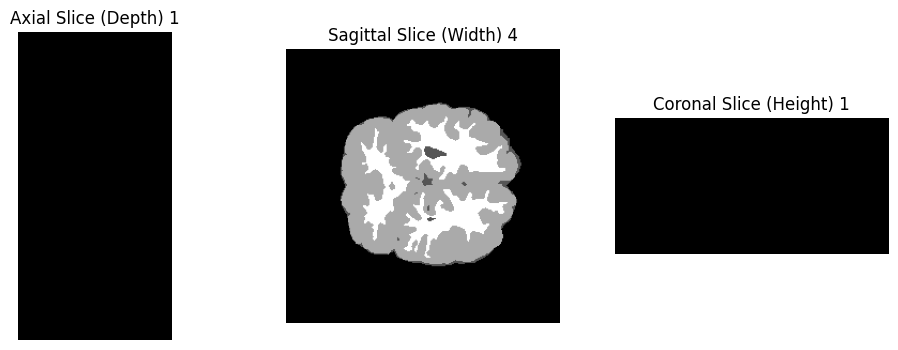

4


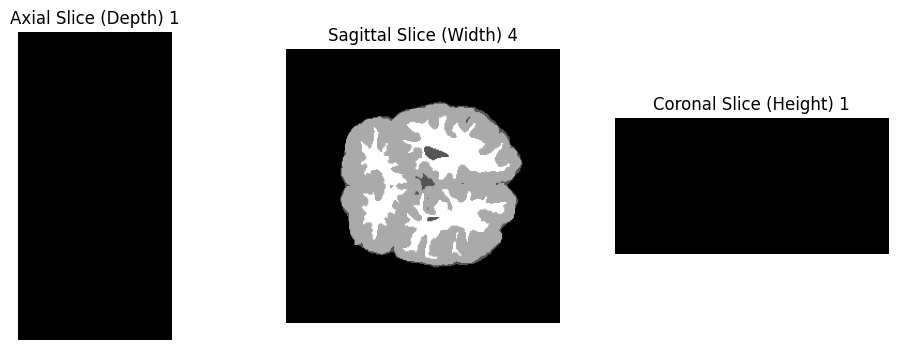

4


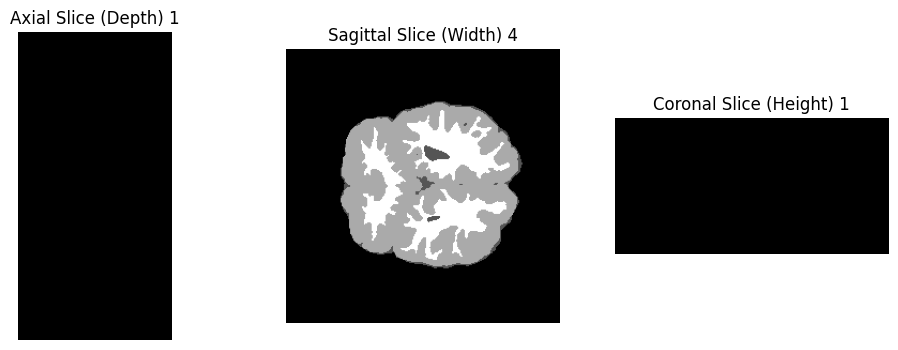

4


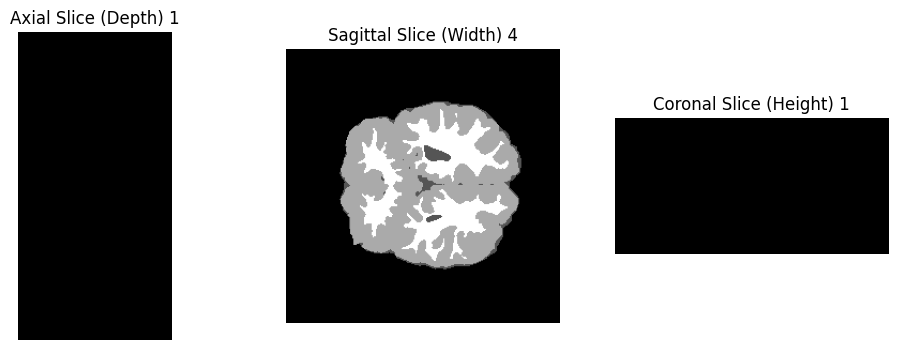

4


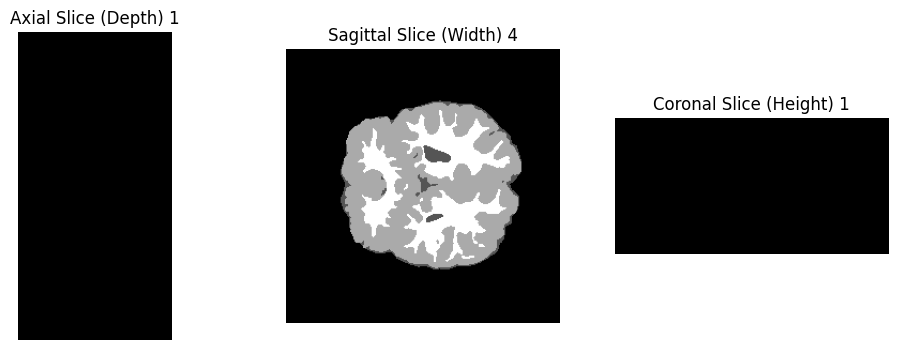

4


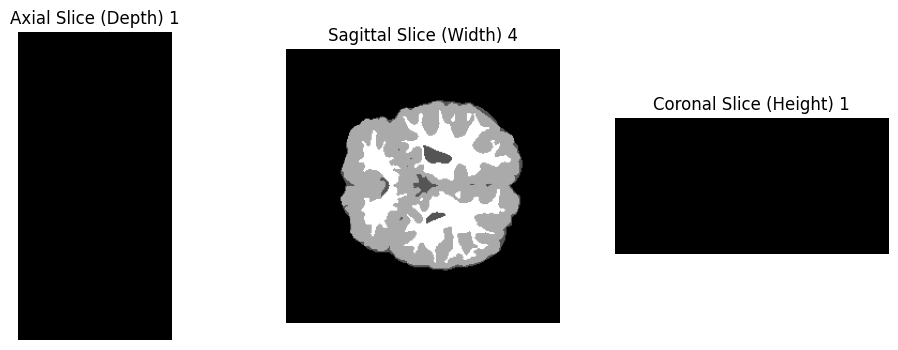

4


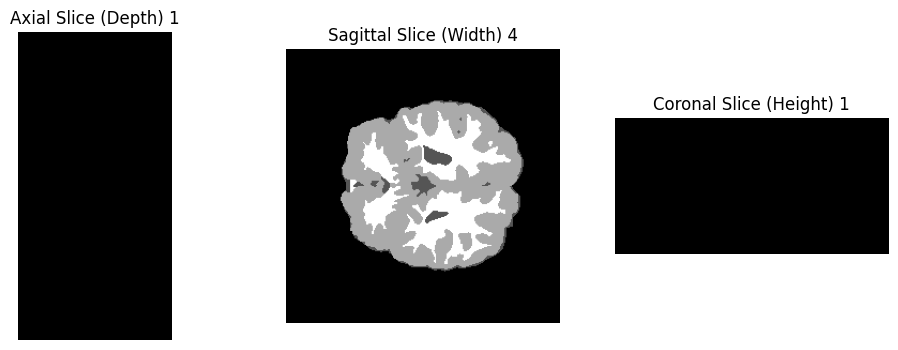

4


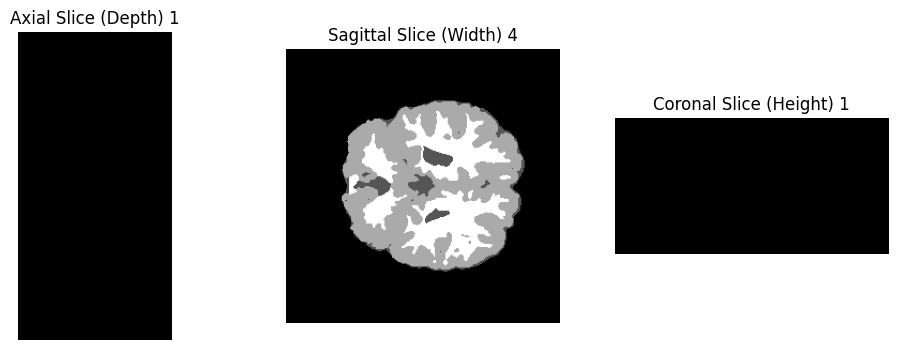

4


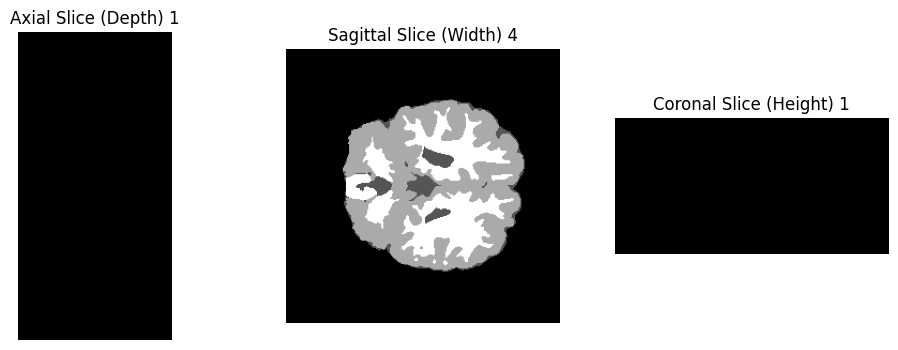

4


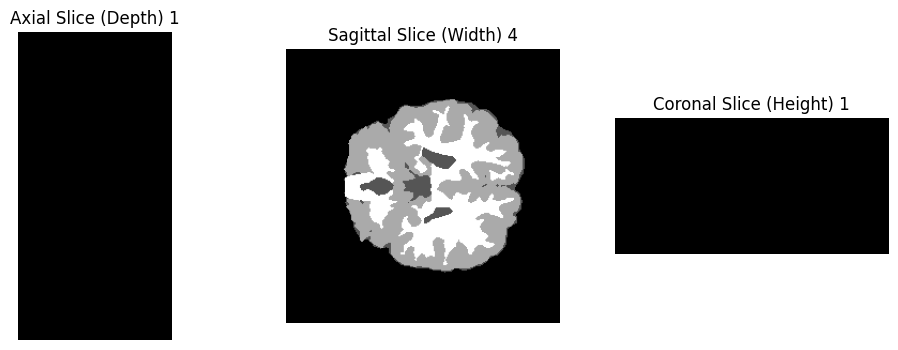

4


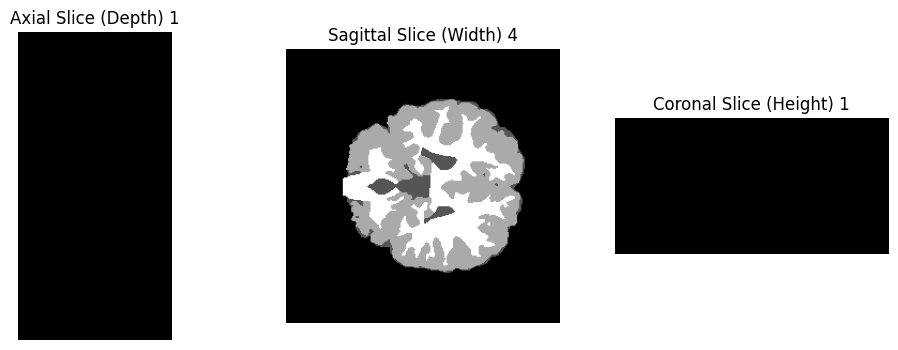

4


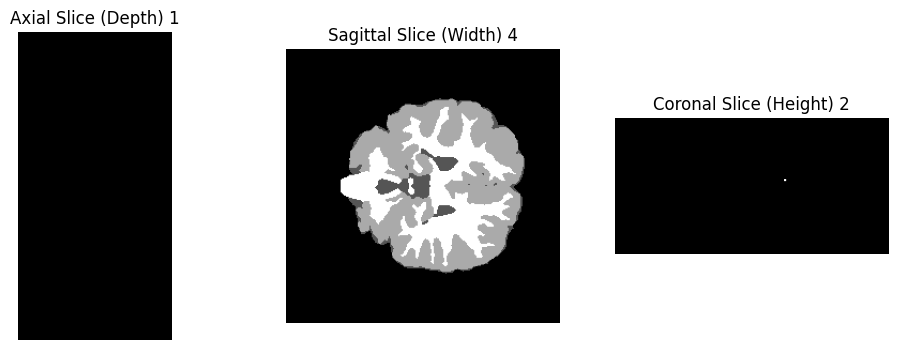

4


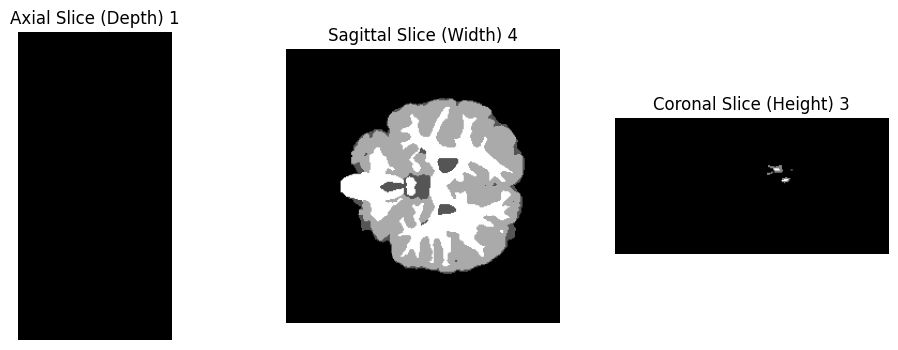

4


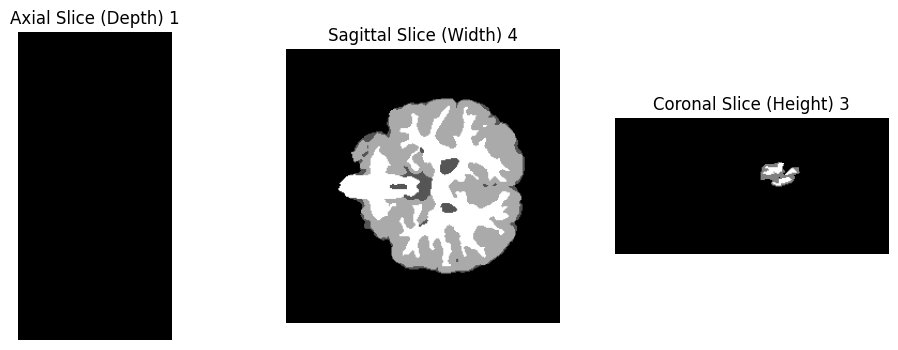

4


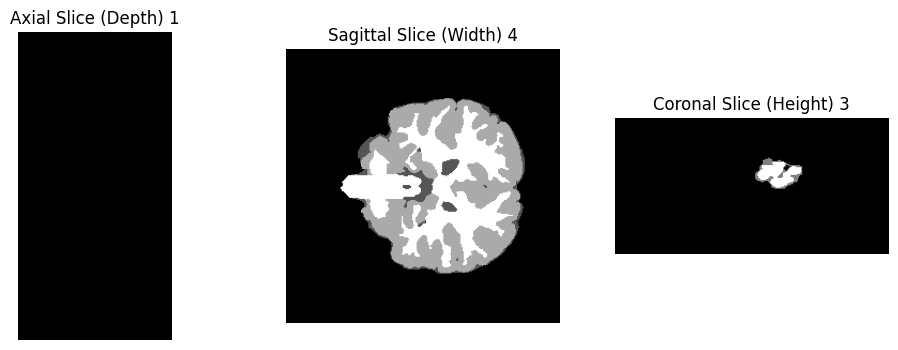

4


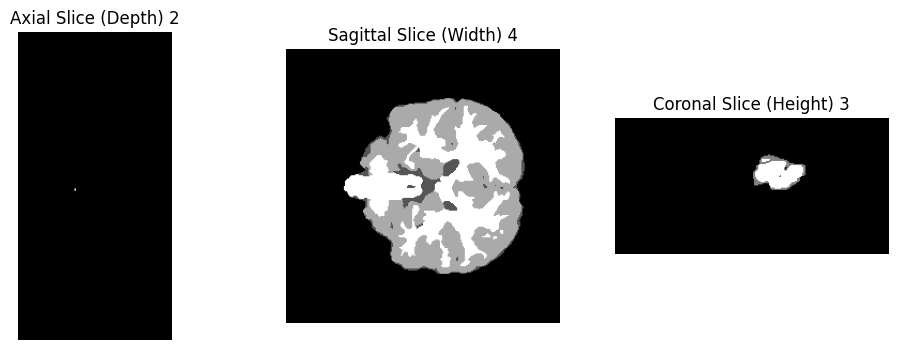

4


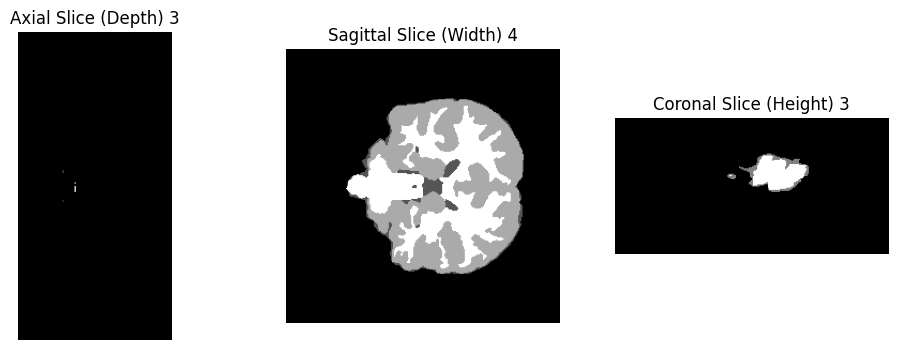

4


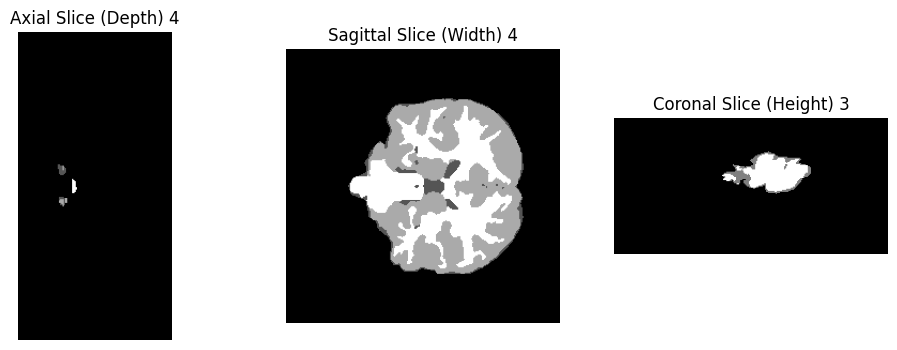

4


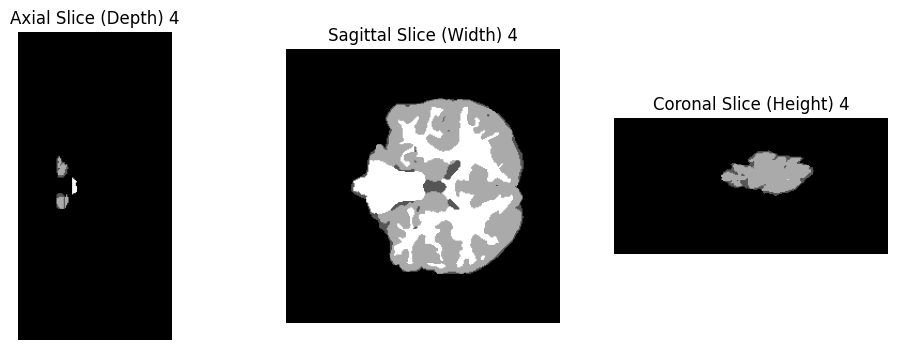

4


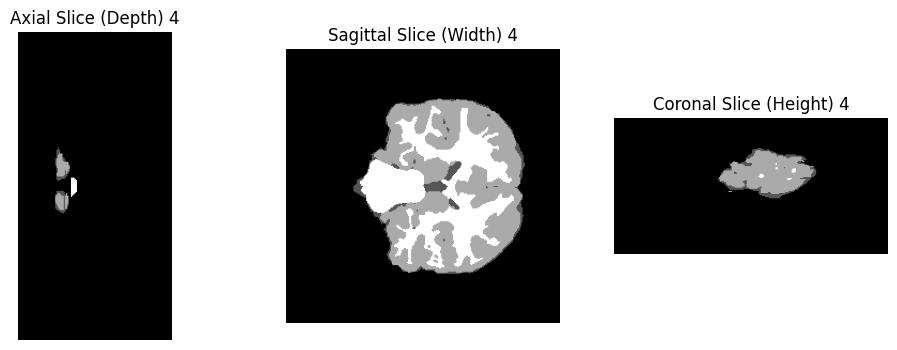

4


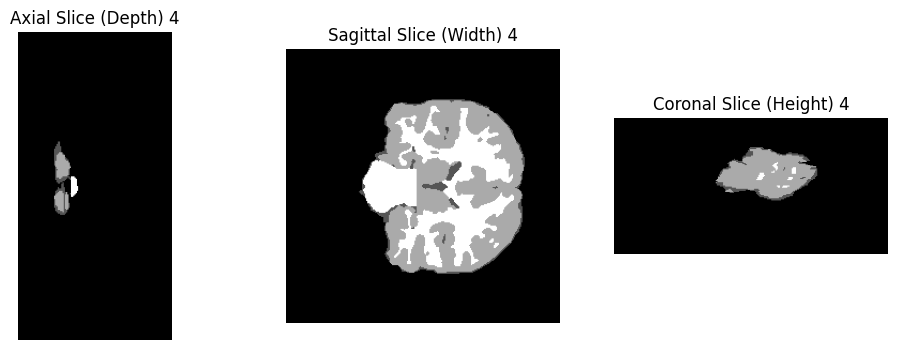

4


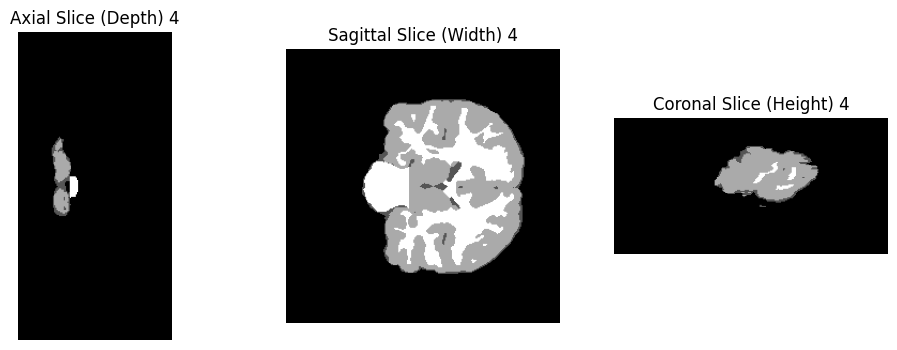

4


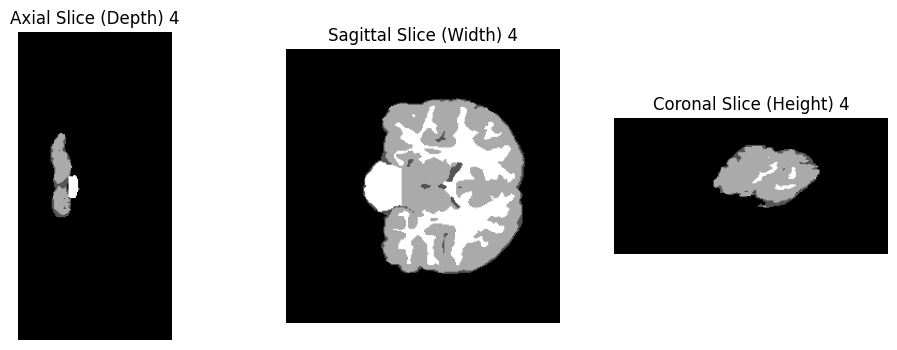

4


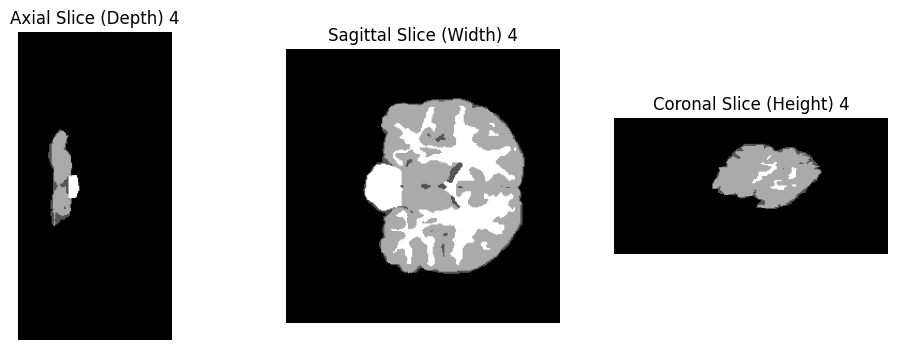

4


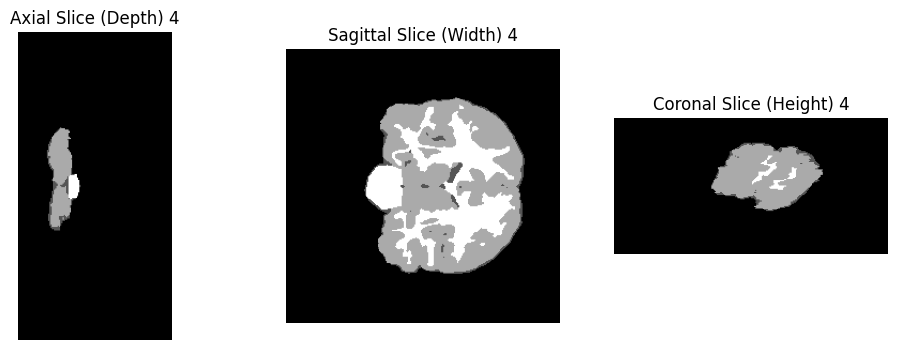

4


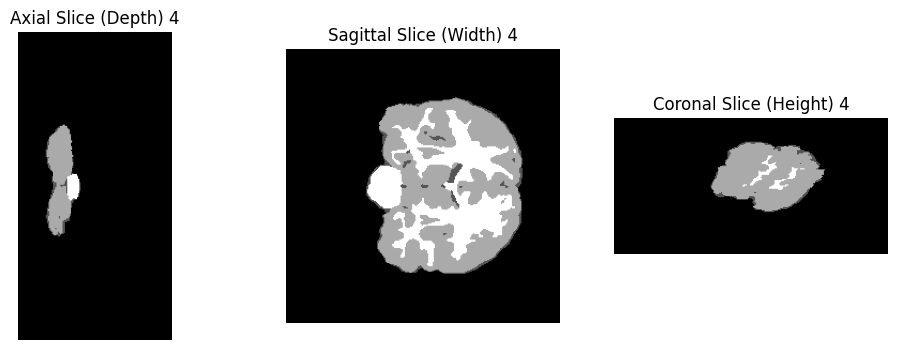

4


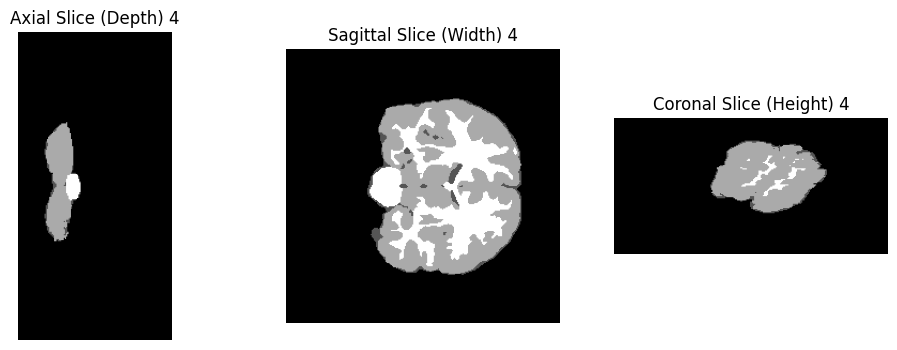

4


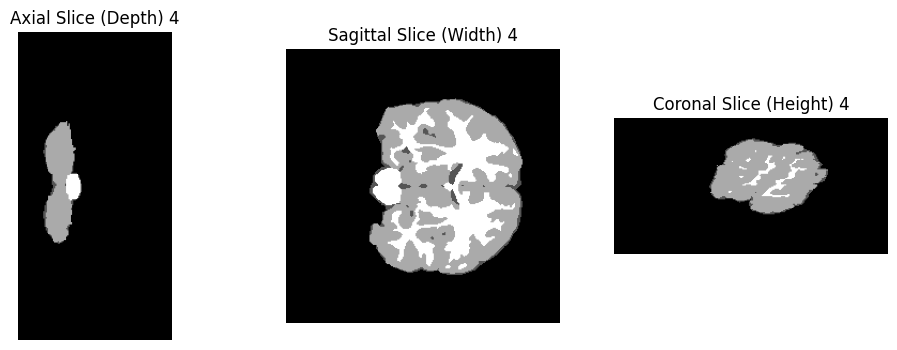

4


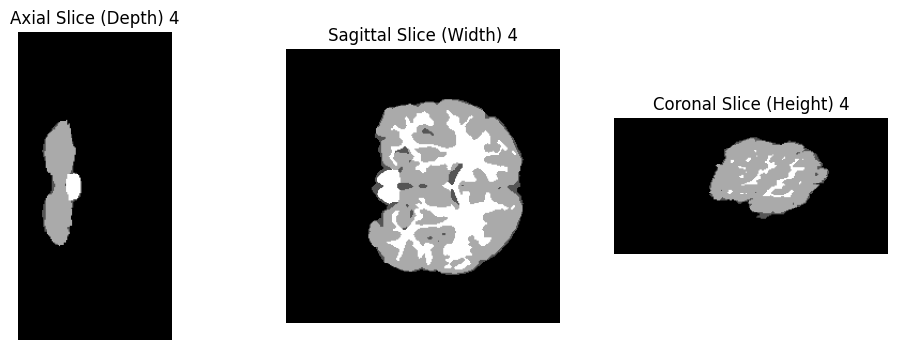

4


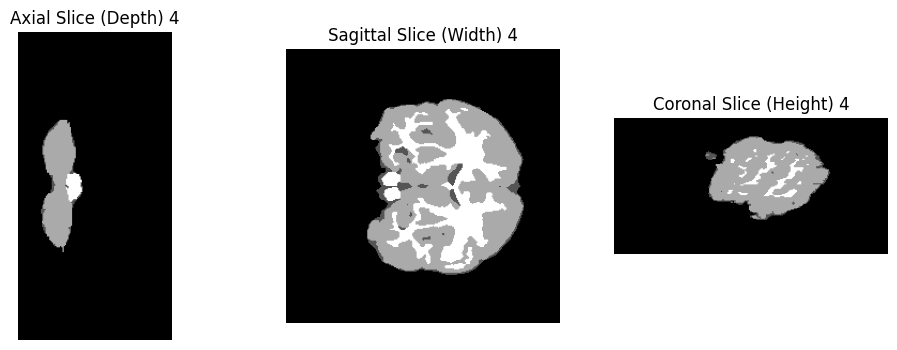

4


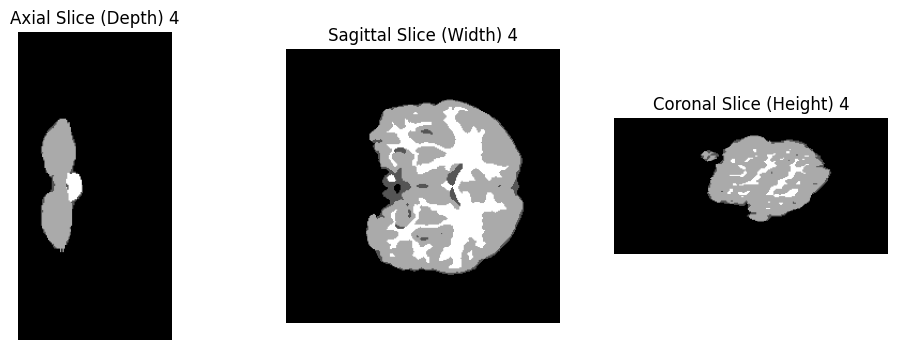

4


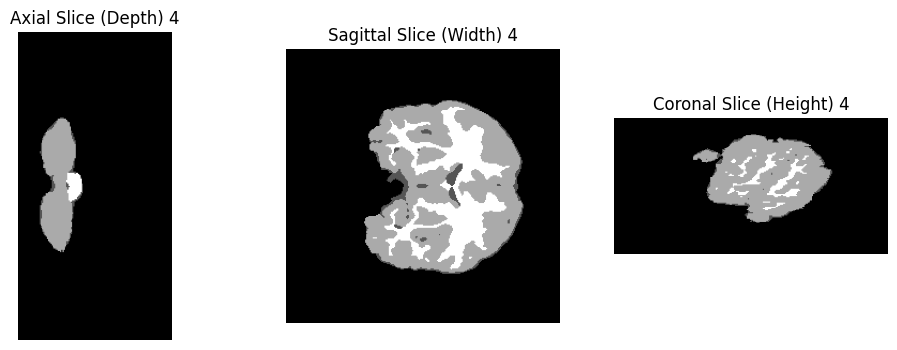

4


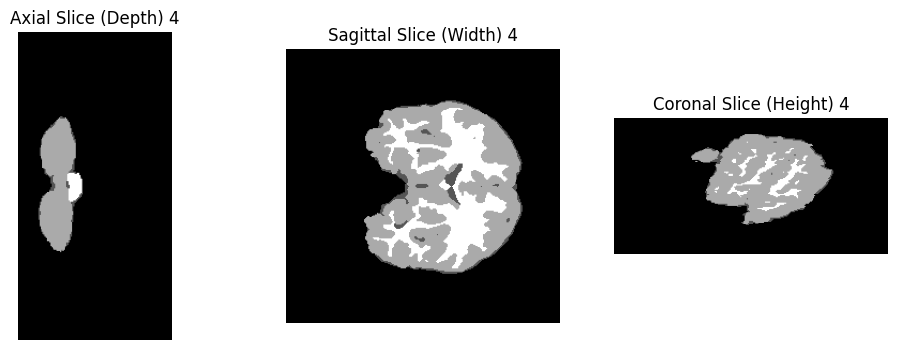

4


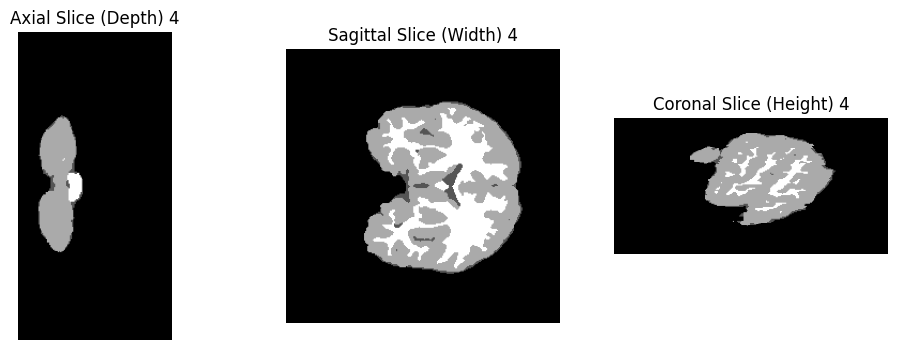

4


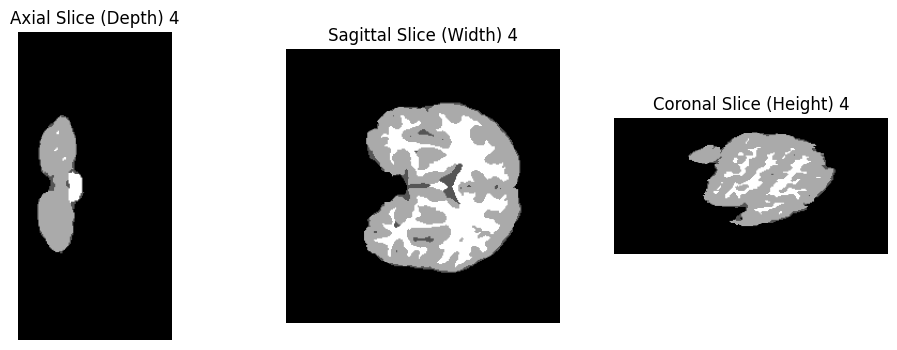

4


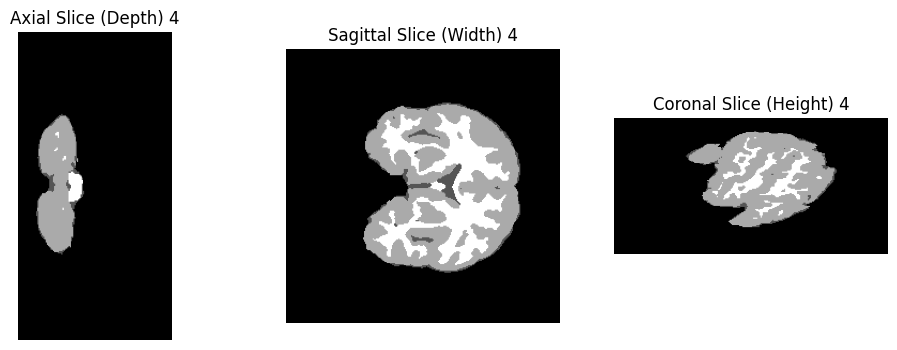

4


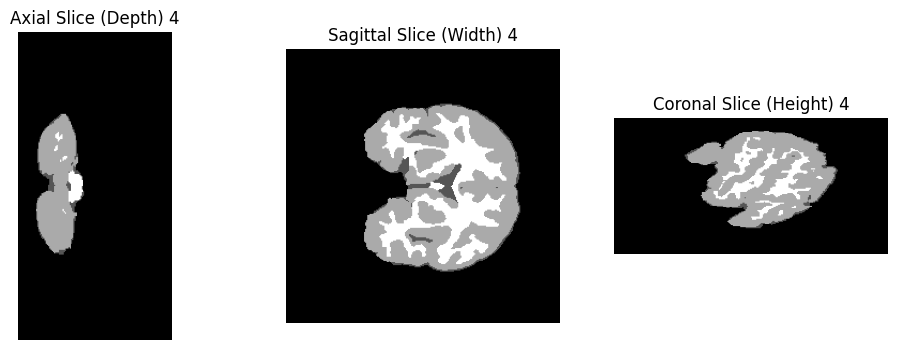

4


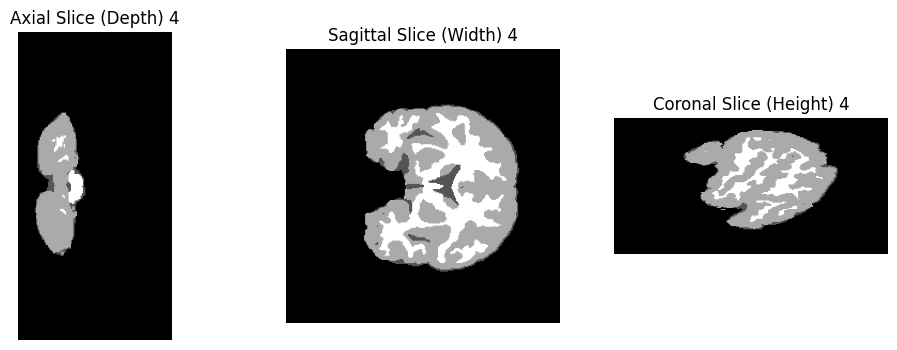

4


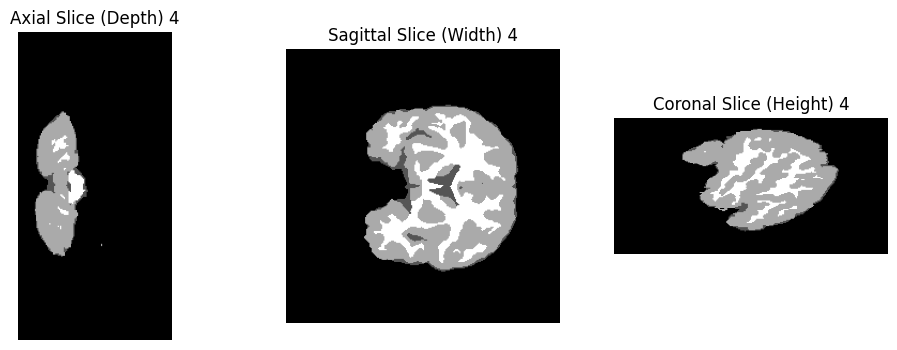

4


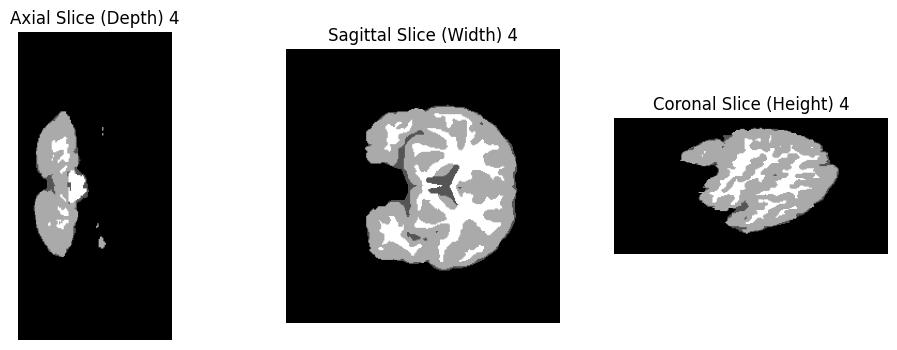

4


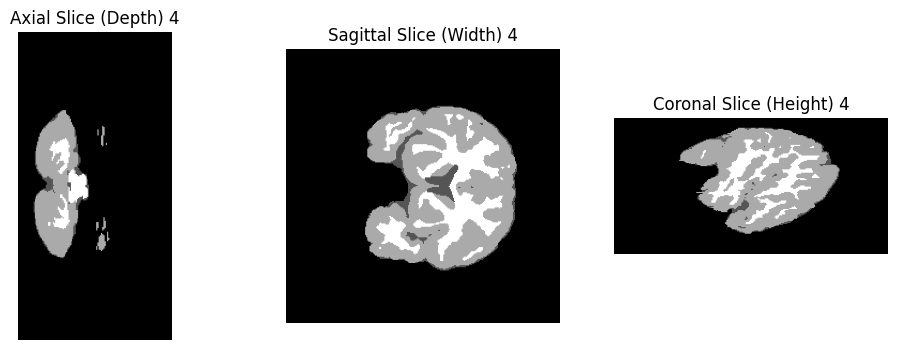

4


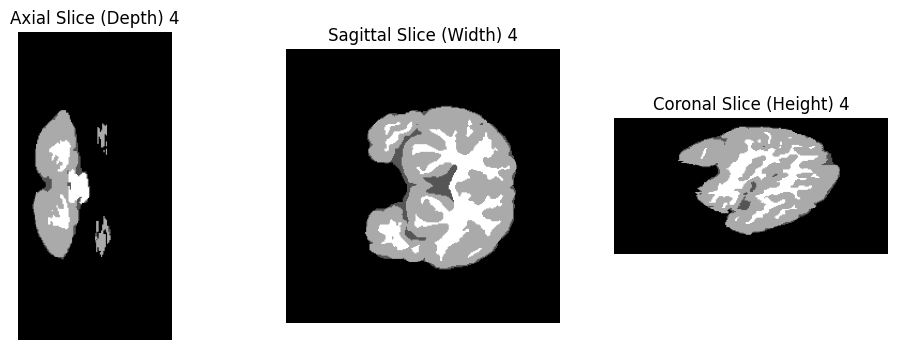

4


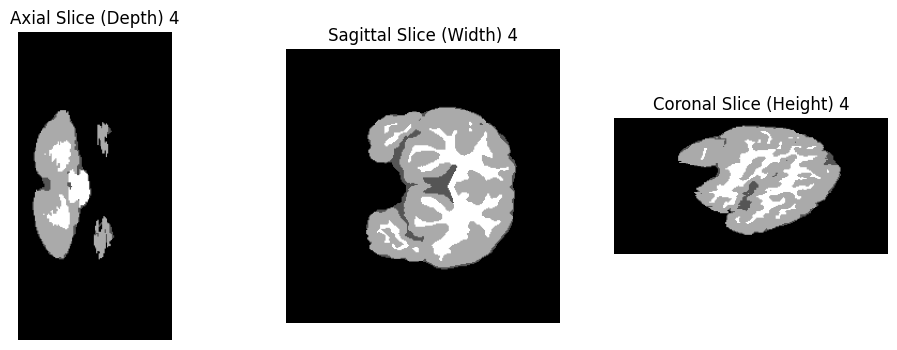

4


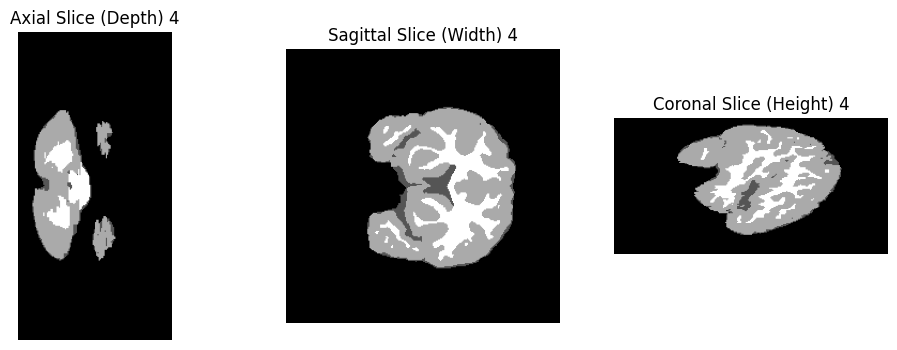

4


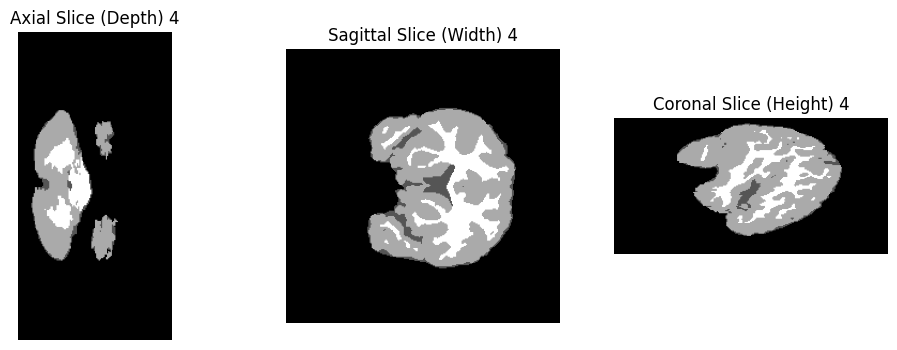

4


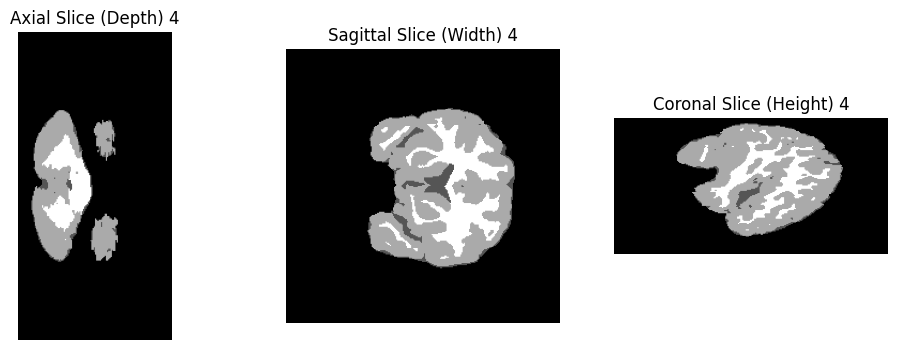

4


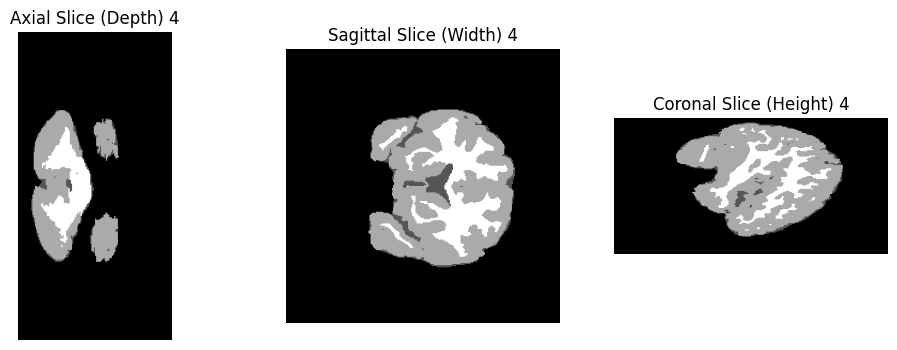

4


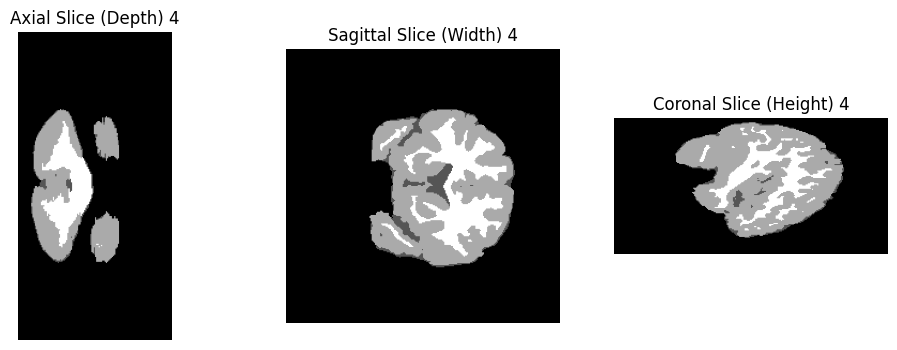

4


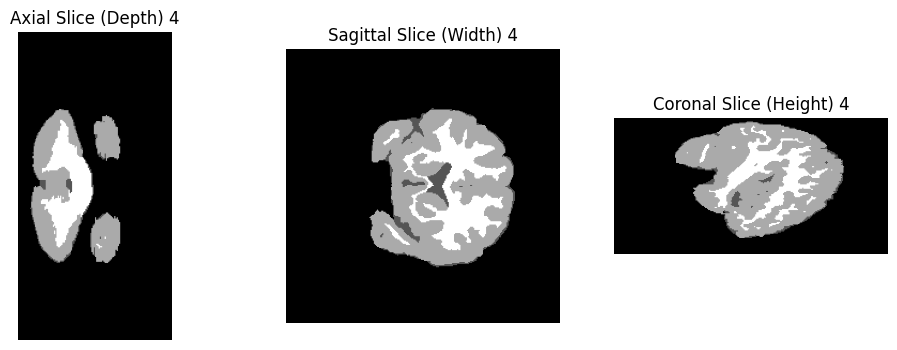

4


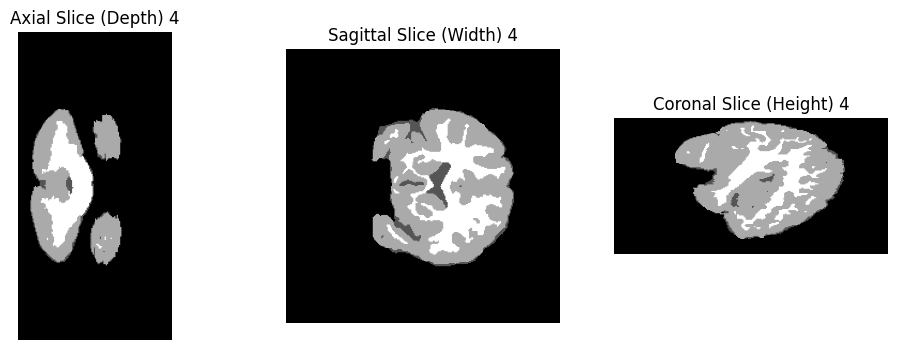

4


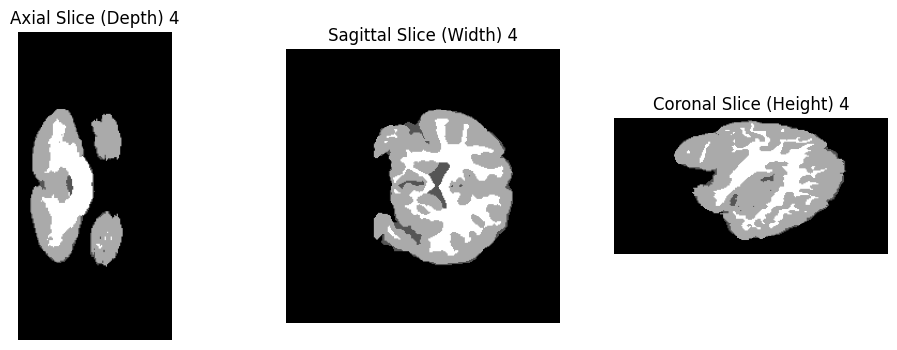

4


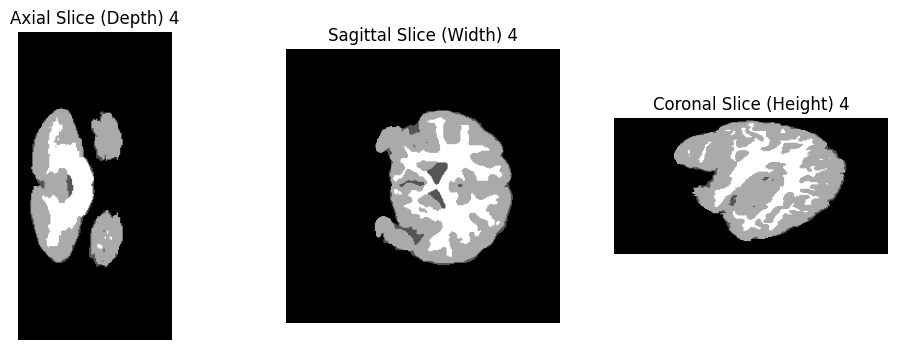

4


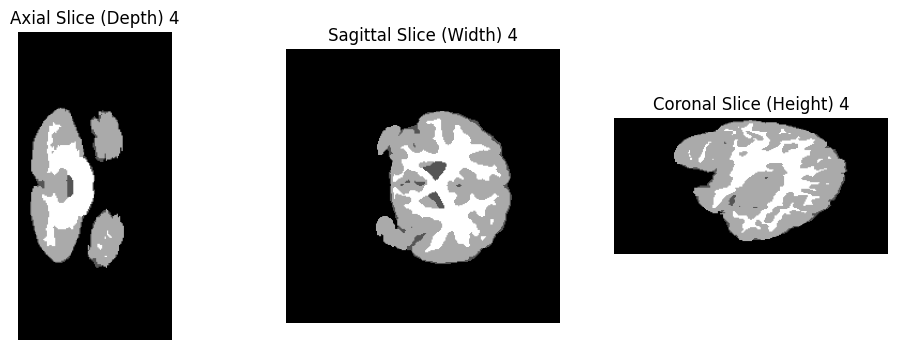

4


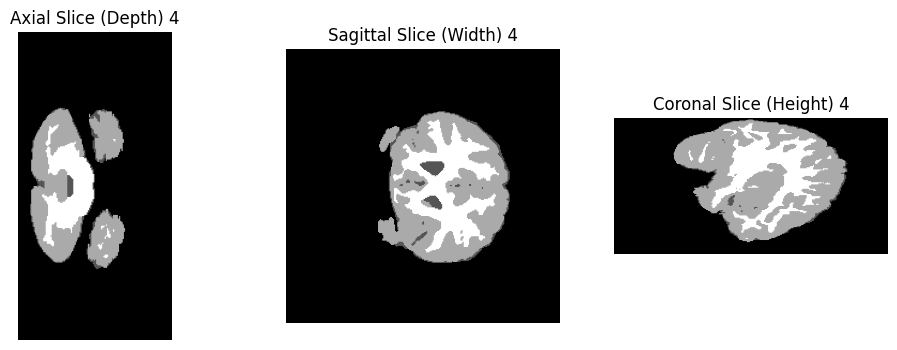

4


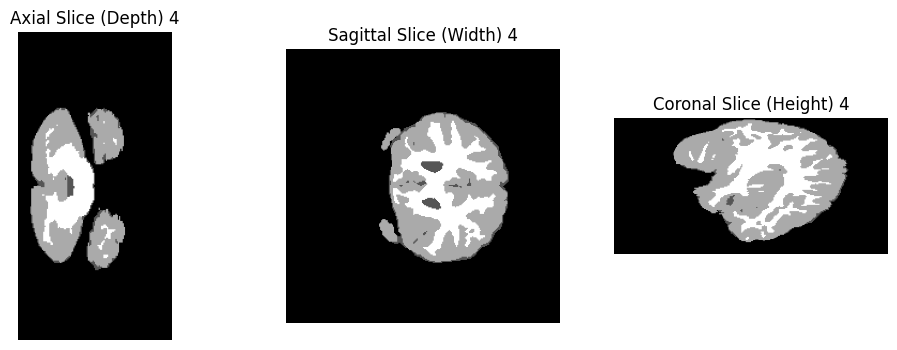

4


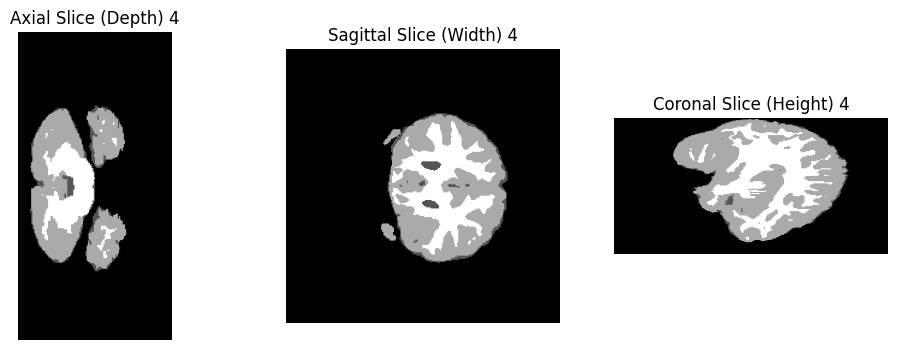

4


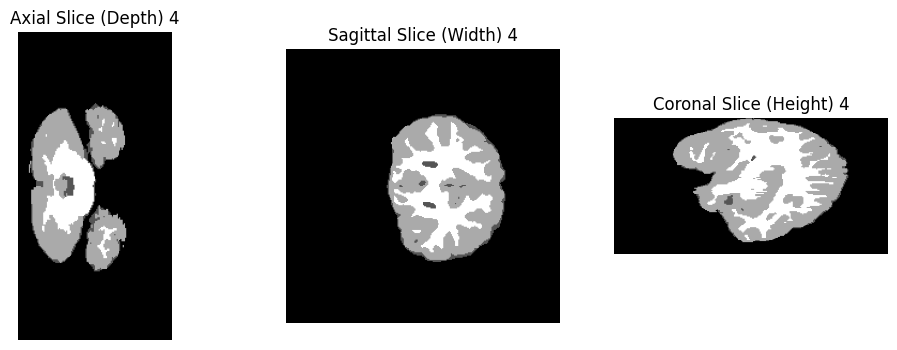

4


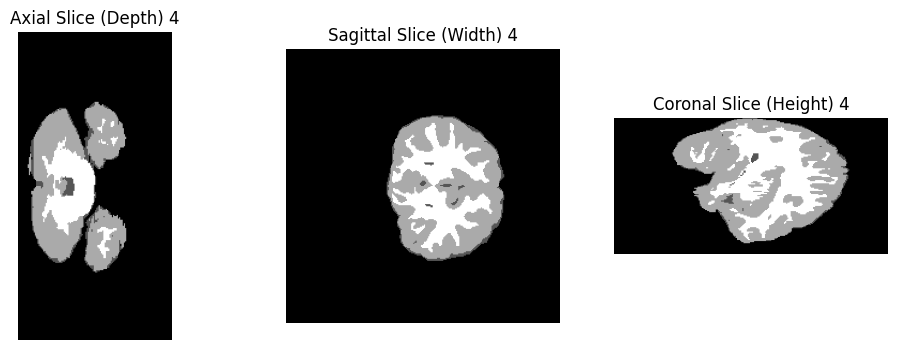

4


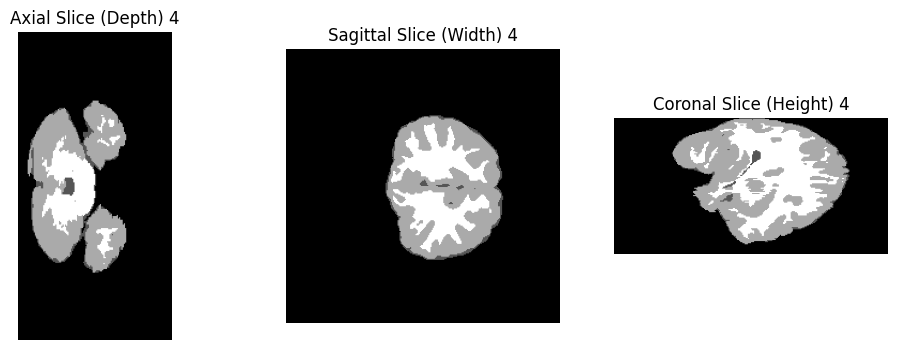

4


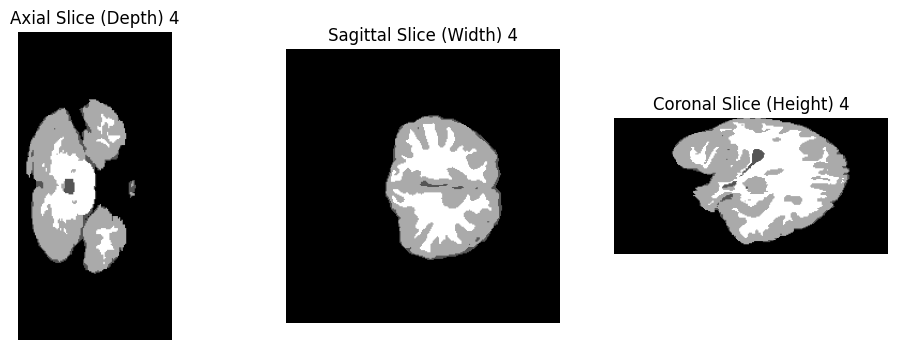

4


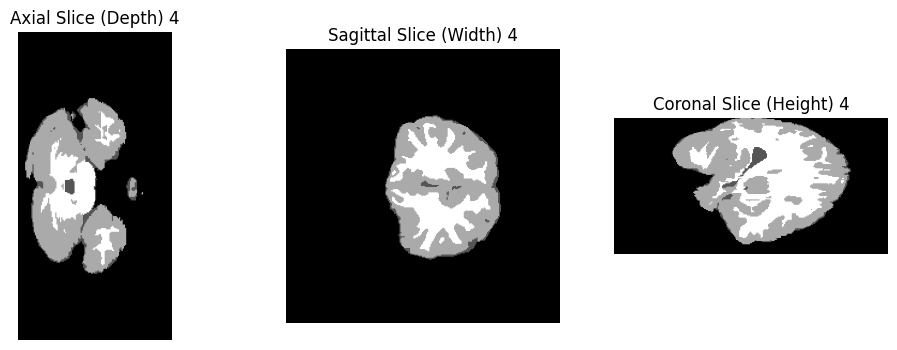

4


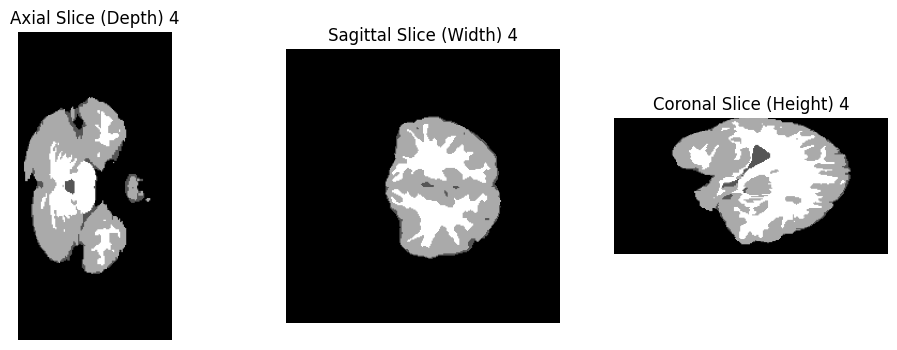

4


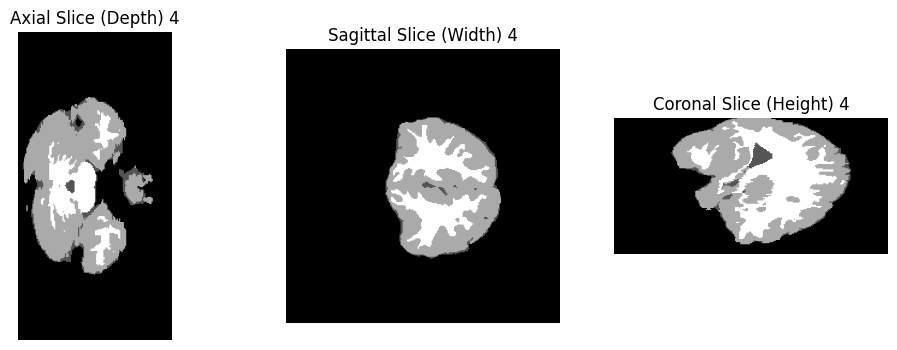

4


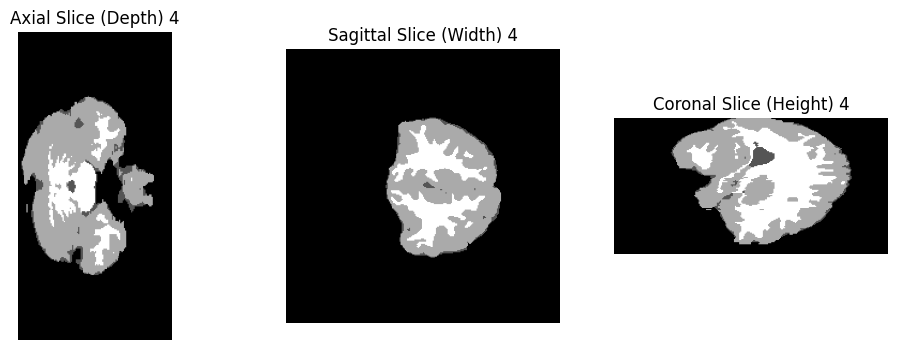

4


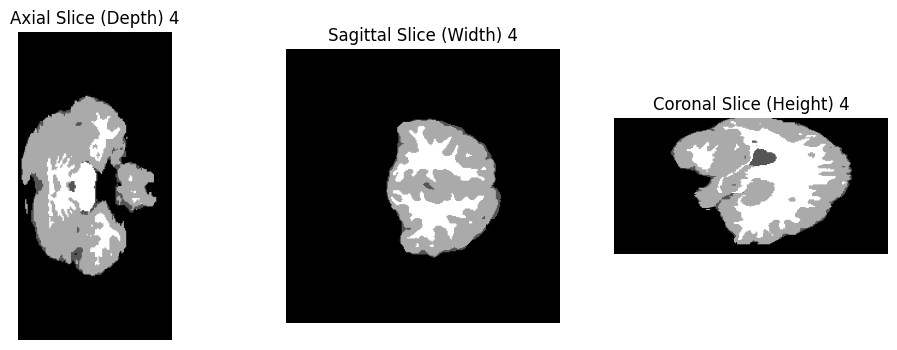

4


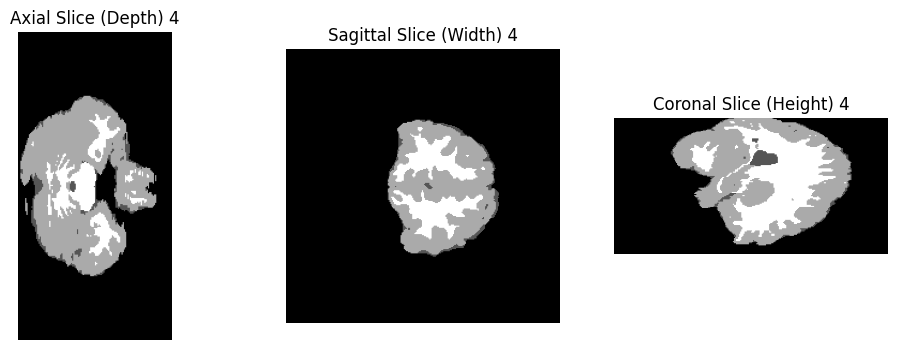

4


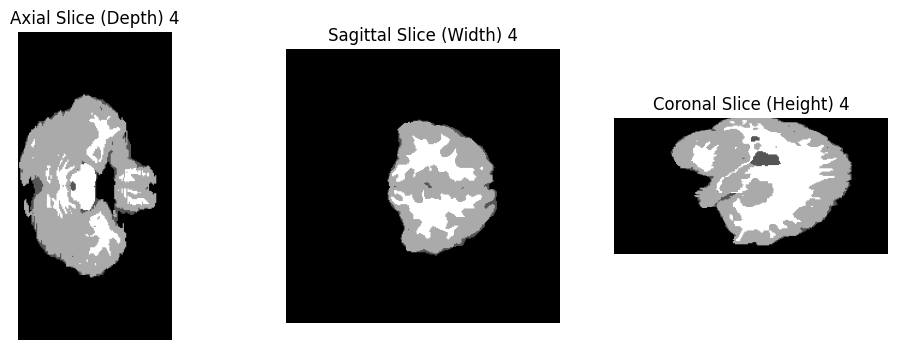

4


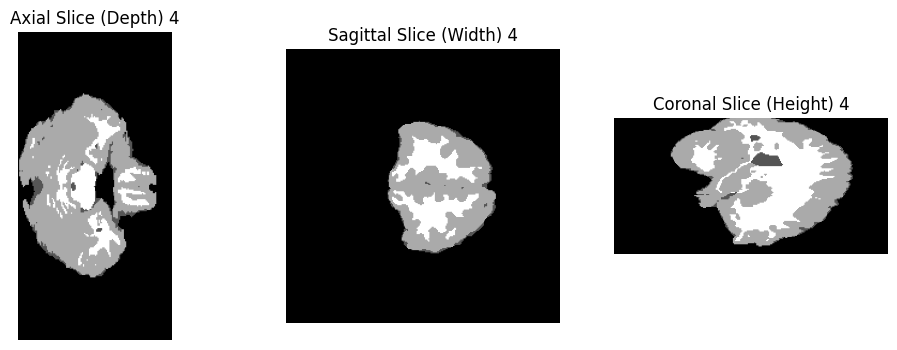

4


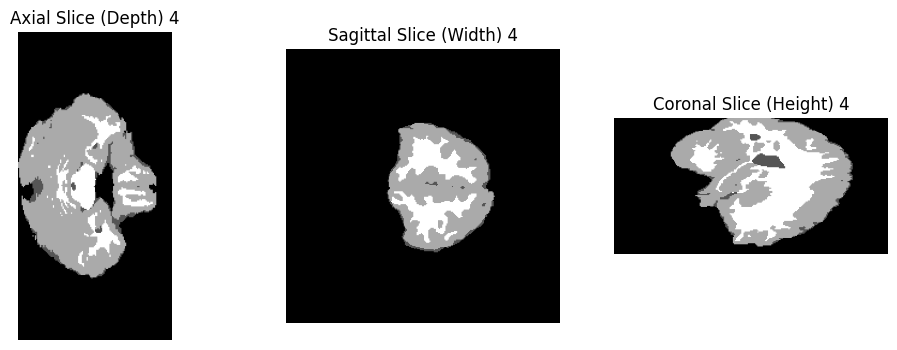

4


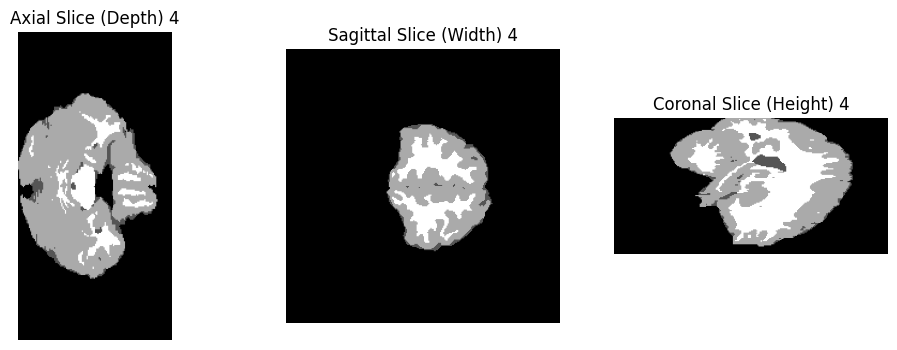

4


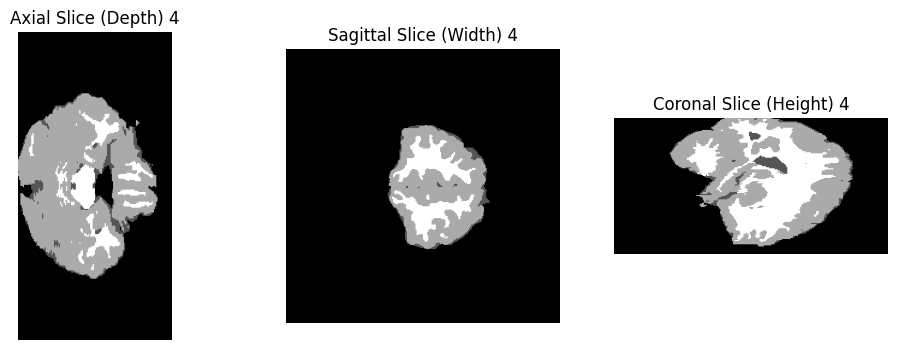

4


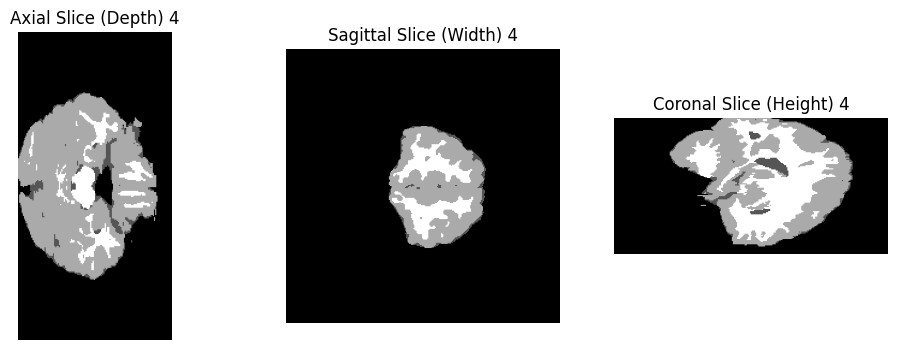

4


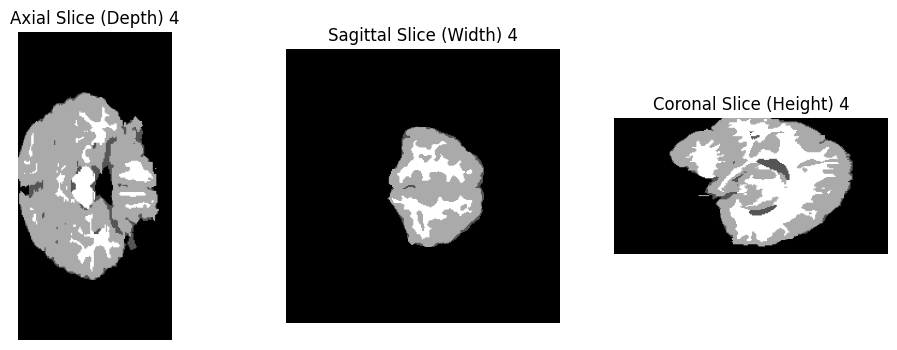

4


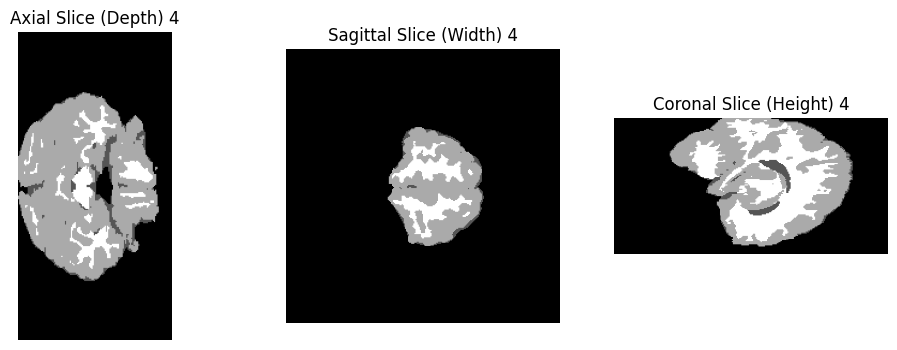

4


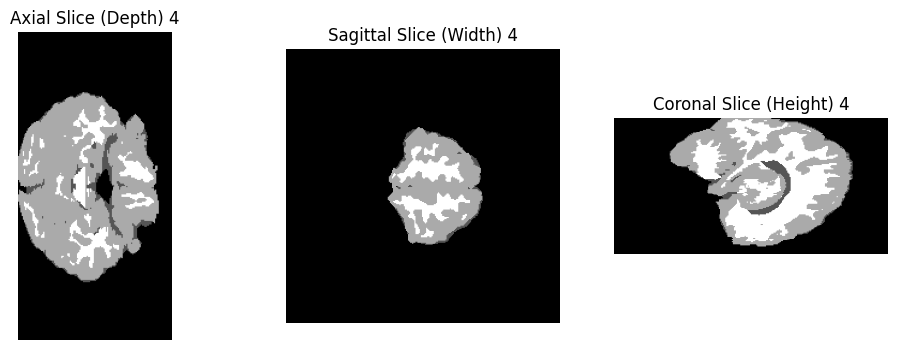

4


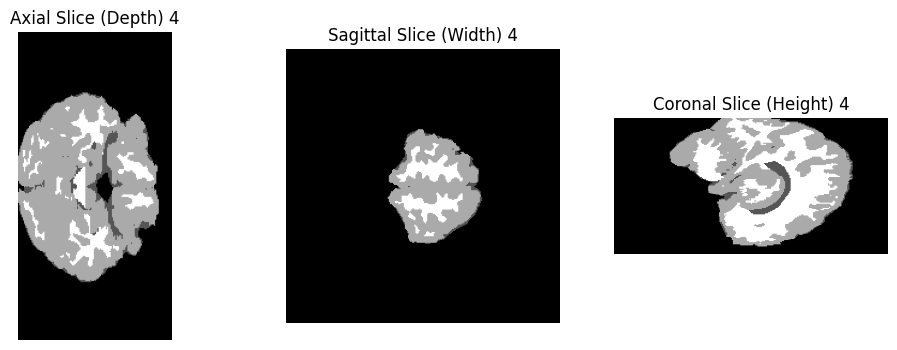

4


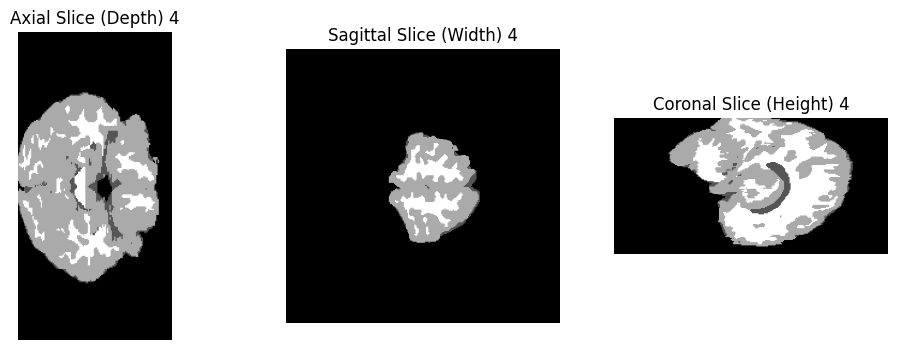

4


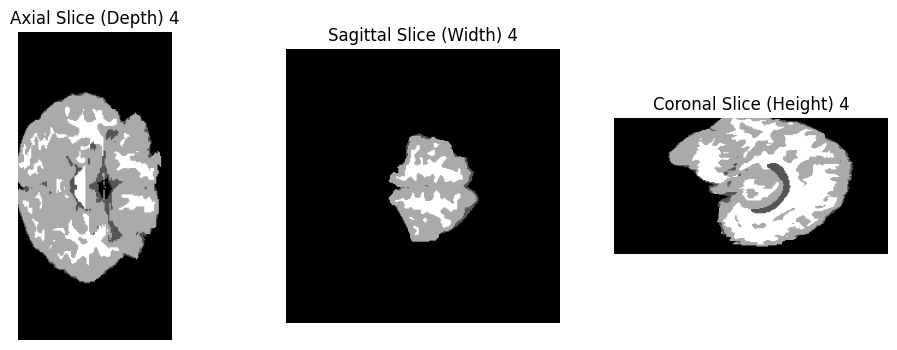

4


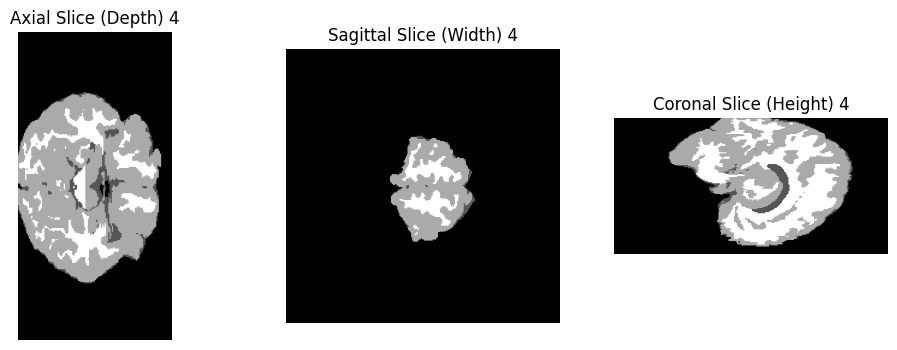

4


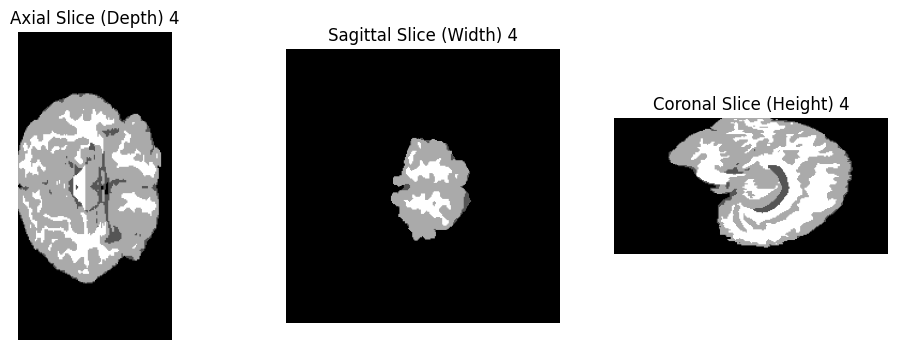

4


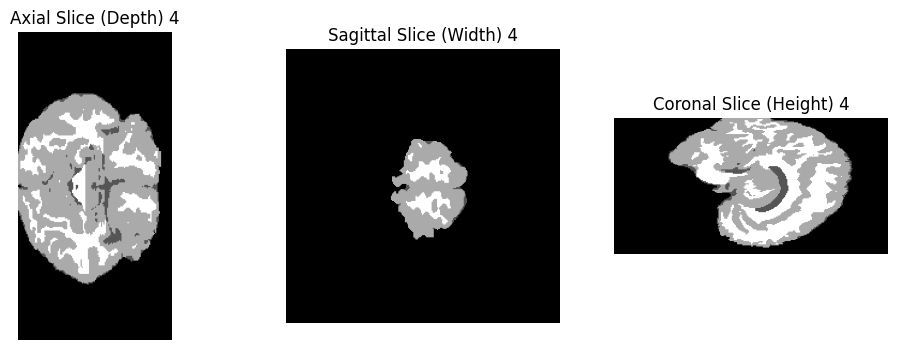

4


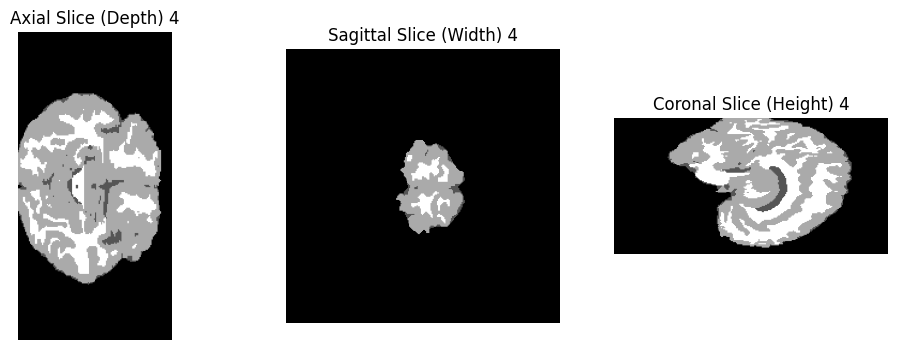

4


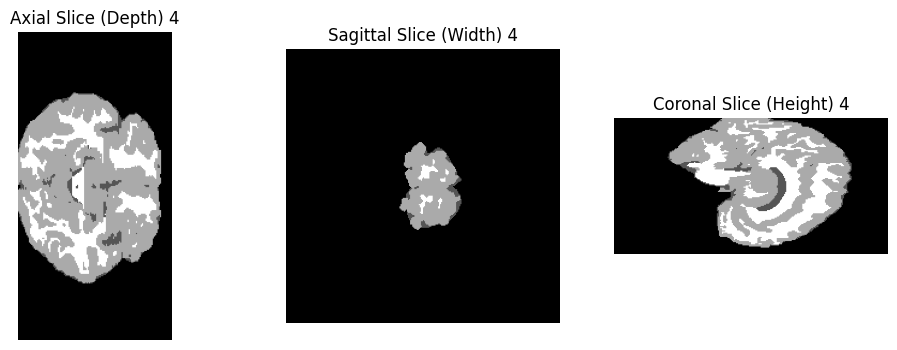

4


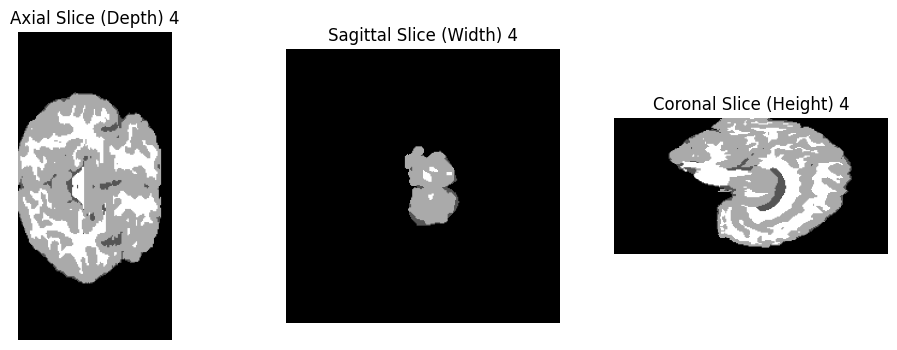

4


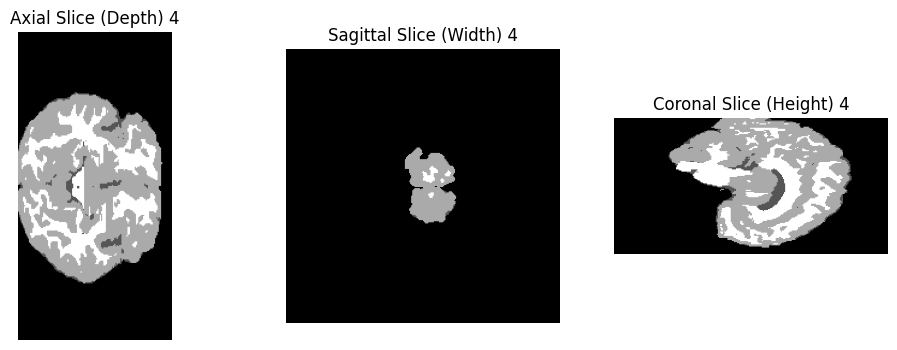

4


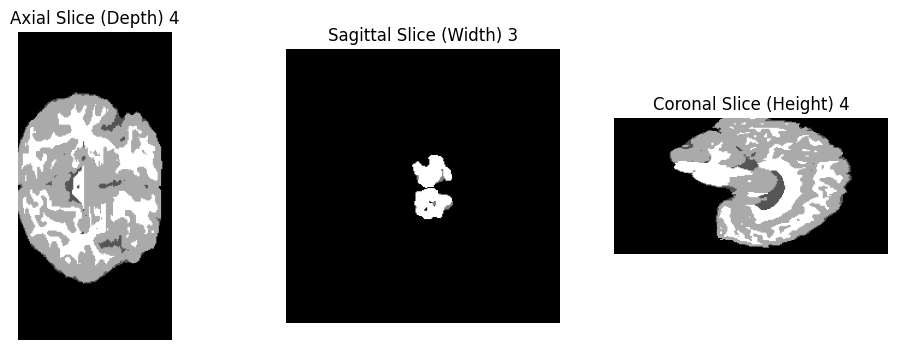

4


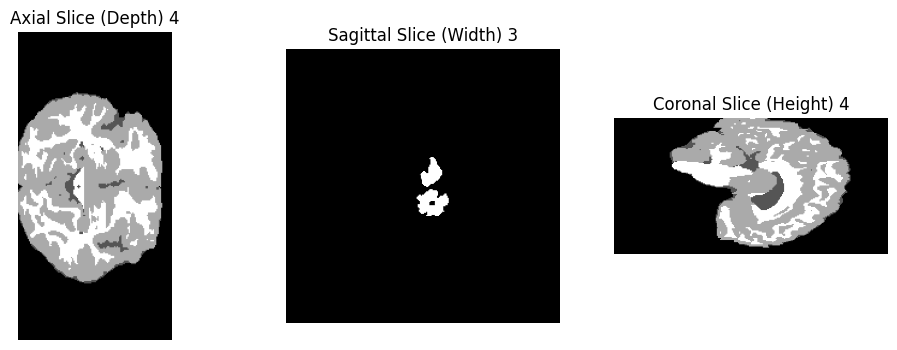

4


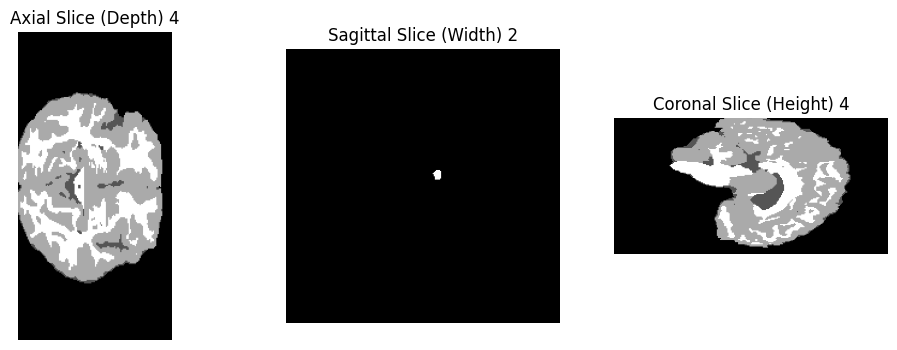

4


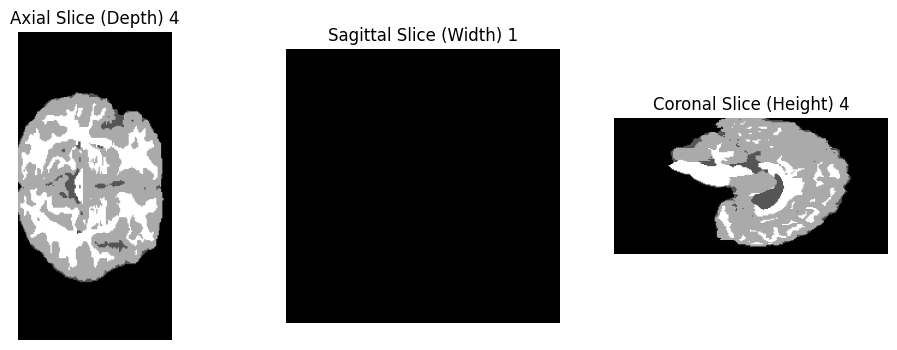

4


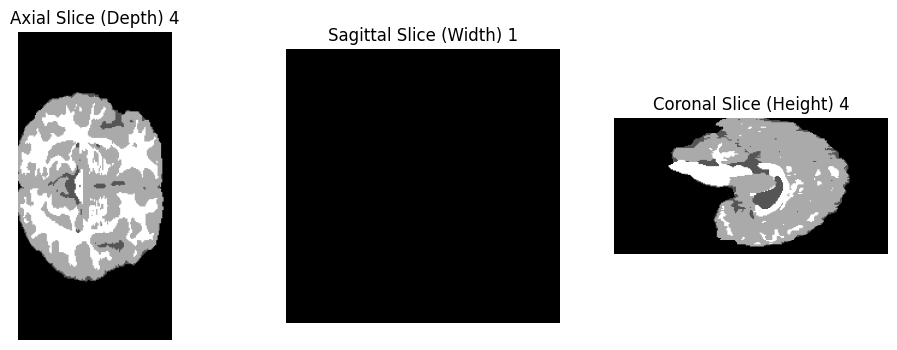

4


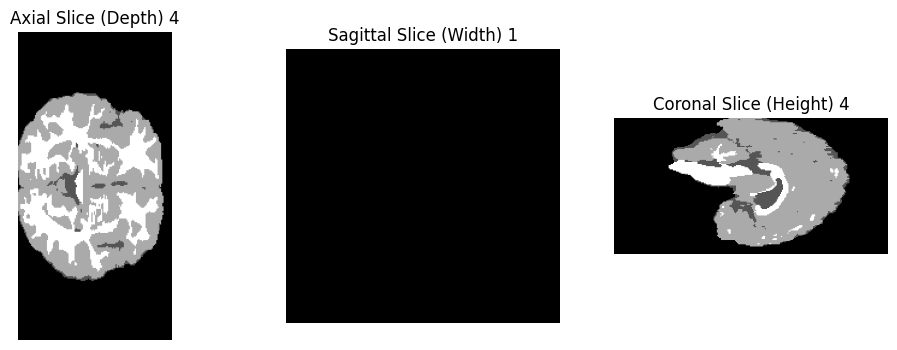

4


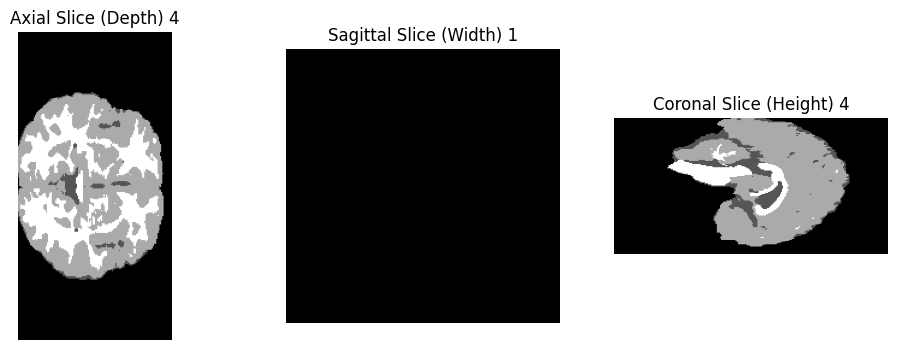

4


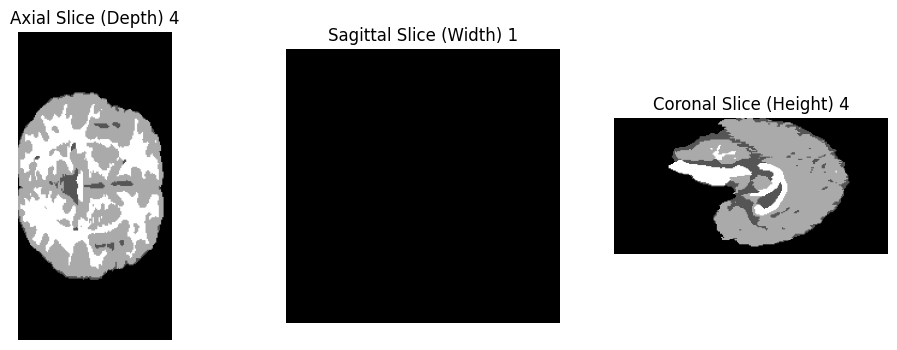

4


In [ ]:
import numpy as np
import matplotlib.pyplot as plt



data = load_mri_image("/content/IBSR_18_segTRI_fill_ana.nii.gz")
temp = []
for sample_no in range(127):
  axial_slice = data[:, :, sample_no]  # Slice along depth axis (z=32)

  # Sagittal Slice (slice along the width axis)
  sagittal_slice = data[:, sample_no, :]  # Slice along width axis (y=32)

  # Coronal Slice (slice along the height axis)
  coronal_slice = data[sample_no, :, :]  # Slice along height axis (x=32)

  # Plot the slices
  fig, axes = plt.subplots(1, 3, figsize=(12, 4))

  unique_segments = np.unique(axial_slice)
  num_segments_axial = len(unique_segments)

  unique_segments = np.unique(sagittal_slice)
  num_segments_sagittal = len(unique_segments)
  temp.append(num_segments_sagittal)
  unique_segments = np.unique(coronal_slice)
  num_segments_coronal = len(unique_segments)
  # Plot each slice
  axes[0].imshow(axial_slice, cmap='gray')
  axes[0].set_title(f"Axial Slice (Depth) {num_segments_axial}")

  axes[1].imshow(sagittal_slice, cmap='gray')
  axes[1].set_title(f"Sagittal Slice (Width) {num_segments_sagittal}")

  axes[2].imshow(coronal_slice, cmap='gray')
  axes[2].set_title(f"Coronal Slice (Height) {num_segments_coronal}")

  # Hide axes for a cleaner view
  for ax in axes:
      ax.axis('off')

  plt.show()
  print(max(temp))

In [ ]:
data = load_mri_image("/content/IBSR_18_segTRI_fill_ana.nii.gz")
sagittal_slices_train = np.zeros((128, 256,256))
for sample_no in range(127):
  sagittal_slices_train[sample_no,:,:] = data[:, sample_no, :]  # Slice along width axis (y=32)


In [ ]:
data_label = load_mri_image("/content/IBSR_18_seg_ana.nii.gz")
sagittal_slices_train_labels = np.zeros((128, 256,256))
for sample_no in range(127):
  sagittal_slices_train_labels[sample_no,:,:] = data_label[:, sample_no, :]  # Slice along width axis (y=32)

In [ ]:
print(sagittal_slices_train.shape)
print(sagittal_slices_train.shape)

(128, 256, 256)
(128, 256, 256)


In [ ]:
train_data = sagittal_slices_train

In [ ]:
train_label = sagittal_slices_train_labels

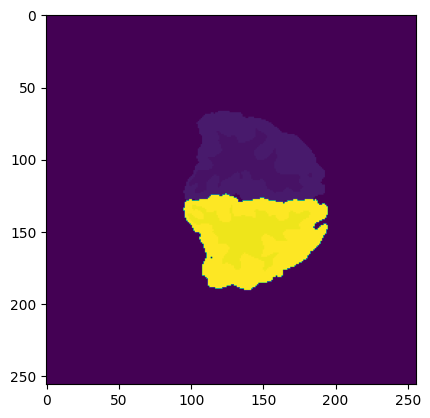

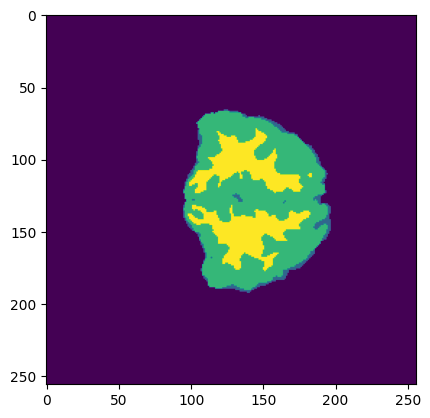

In [ ]:
plt.imshow(train_label[100,:,:])
plt.show()
plt.imshow(train_data[100,:,:])
plt.show()

In [ ]:
train_data = np.expand_dims(train_data, axis=-1)
train_label = np.expand_dims(train_label, axis=-1)

In [ ]:
print(train_data.shape)
print(train_label.shape)

(128, 256, 256, 1)
(128, 256, 256, 1)


In [ ]:
train_data =np.squeeze(train_data,axis=-1)

In [ ]:
import numpy as np
from tensorflow.keras.utils import Sequence
import cv2
import tensorflow as tf
class DataGenerator(Sequence):
    def __init__(self, all_filenames, input_size = (256, 256), batch_size = 32, shuffle = True, seed = 123, encode: dict = None, encode_with_kmean = None, color_mode = 'hsv', function = None) -> None:
        super(DataGenerator, self).__init__()
        assert (encode != None and encode_with_kmean == None) or (encode == None and encode_with_kmean != None), 'Not empty !'
        assert color_mode == 'hsv' or color_mode == 'rgb' or color_mode == 'gray'
        self.all_filenames = all_filenames
        self.input_size = input_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.color_mode = color_mode
        self.encode = encode
        self.function = function
        self.kmean = encode_with_kmean
        np.random.seed(seed)
        self.on_epoch_end()
    def processing(self, mask):
        d = list(map(lambda x: self.encode[tuple(x)], mask.reshape(-1,3)))
        return np.array(d).reshape(*self.input_size, 1)
    def __len__(self):
        return int(np.floor(len(self.all_filenames) / self.batch_size))
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        all_filenames_temp = [self.all_filenames[k] for k in indexes]
        X, Y = self.__data_generation(all_filenames_temp)
        return X, Y
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.all_filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    def __data_generation(self, all_filenames_temp):
        batch = len(all_filenames_temp)
        if self.color_mode == 'gray':
            X = np.empty(shape=(batch, *self.input_size, 1))
        else:
            X = np.empty(shape=(batch, *self.input_size,3))
        Y = np.empty(shape=(batch, *self.input_size, 1))
        for i, (fn, label_fn) in enumerate(all_filenames_temp):
            # img
            img = cv2.imread(fn)
            if self.color_mode == 'hsv':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            elif self.color_mode == 'rgb':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            elif self.color_mode == 'gray':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = tf.expand_dims(img, axis = 2)
            img = tf.image.resize(img, self.input_size, method = 'nearest')
            img = tf.cast(img, tf.float32)
            img /= 255.

            #mask
            mask = cv2.imread(label_fn, 0)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            mask = tf.image.resize(mask, self.input_size, method= 'nearest')
            mask = np.array(mask)
            if self.function:
                mask = self.function(mask)
            if self.encode:
                mask = self.processing(mask)
            if self.kmean:
                mask = self.kmean.predict(mask.reshape(-1,3)).reshape(*self.input_size, 1)
            mask = tf.cast(mask, tf.float32)
            X[i,] = img
            Y[i,] = mask
        return X, Y

In [ ]:
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import sklearn
import cv2
import tensorflow as tf
from sklearn.cluster import KMeans

def encode_label(mask):
    # input (batch, rows, cols, channels)
    colors = np.unique(mask.reshape(-1,3), axis = 0)
    encoder = dict((tuple(j),i) for i,j in enumerate(colors)) # key is tuple
    _label = dict((j, list(i)) for i,j in encoder.items())
    with open('label.pickle', 'wb') as handel:
        pickle.dump(_label, handel, protocol= pickle.HIGHEST_PROTOCOL)
    return encoder
def encode_label_with_Kmeans(mask, classes):
    kmean = KMeans(classes, max_iter= 400)
    kmean.fit(mask)
    pred = kmean.predict(mask)
    classes_real =  len(set(pred))
    print(f'classes: {classes_real}')
    label = dict((j, i.tolist()) for i,j in list(zip(mask, pred))) # key is tuple
    with open('label.pickle', 'wb') as handel:
        pickle.dump(label, handel, protocol= pickle.HIGHEST_PROTOCOL)
    with open('kmean.pickle', 'wb') as handle:
        pickle.dump(kmean, handle, protocol= pickle.HIGHEST_PROTOCOL)
    return kmean
def decode_label(predict, label):
    d = list(map( lambda x: label[int(x)], predict.reshape(-1,1)))
    img =  np.array(d).reshape(predict.shape[0], predict.shape[1], 3)
    return img
def DataLoader(all_train_filename, all_mask,  all_valid_filename = None, input_size = (256,256), batch_size = 4, shuffle = True, seed = 123, color_mode = 'hsv', function = None, encode_with_kmeans = False, classes = 0) -> None:
    mask_folder = sklearn.utils.shuffle(all_mask, random_state = 47)[:16]
    mask = [tf.image.resize(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB), (128, 128), method = 'nearest') for img in mask_folder ]
    mask = np.array(mask)
    kmean = None
    encode = None
    if function and encode_with_kmeans == False:
        mask = function(mask)
    if encode_with_kmeans == False:
        encode = encode_label(mask)
    elif encode_with_kmeans == True:
        kmean = encode_label_with_Kmeans(mask.reshape(-1,3), classes)
    train = DataGenerator(all_train_filename, input_size, batch_size , shuffle, seed, encode, kmean, color_mode, function)
    if all_valid_filename == None:
        return train, None
    else:
        valid = DataGenerator(all_valid_filename, input_size, batch_size, shuffle, seed, encode, kmean, color_mode, function)
        return train, valid

In [ ]:
import cv2
import tensorflow as tf
import numpy as np
def predict(model, image_test, label, color_mode, size):
    image = cv2.imread(image_test)
    if color_mode == 'hsv':
        image_cvt = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    elif color_mode == 'rgb':
        image_cvt = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    elif color_mode == 'gray':
        image_cvt = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_cvt = tf.expand_dims(image_cvt, axis = 2)
    image_cvt = tf.image.resize(image_cvt, size, method= 'nearest')
    image_cvt = tf.cast(image_cvt, tf.float32)
    image_norm = image_cvt / 255.
    image_norm = tf.expand_dims(image_norm, axis= 0)
    new_image = model(image_norm)
    image_argmax = np.argmax(tf.squeeze(new_image, axis = 0), axis = 2)
    image_decode = decode_label(image_argmax, label)
    predict_img = tf.cast(tf.image.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), size, method = 'nearest'), tf.float32) * 0.7 + image_decode * 0.3
    return np.floor(predict_img).astype('int'), new_image

In [ ]:
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf

import numpy as np
def show_history(history, validation : bool = False):
    if validation:
        # Loss
        fig, axes = plt.subplots(figsize= (20,5))
        # Train
        axes.plot(history.epoch, history.history['loss'], color= 'r',  label = 'Train')
        axes.plot(history.epoch, history.history['val_loss'], color = 'b', label = 'Val')
        axes.set_xlabel('Epoch')
        axes.set_ylabel('Loss')
        axes.legend()
        plt.savefig('loss.jpg')
        plt.show()
        # Acc
        fig, axes = plt.subplots(figsize= (20,5))
        # Train
        axes.plot(history.epoch, history.history['acc'], color= 'r',  label = 'Train')
        axes.plot(history.epoch, history.history['val_acc'], color = 'b', label = 'Val')
        axes.set_xlabel('Epoch')
        axes.set_ylabel('Acc')
        axes.legend()
        plt.savefig('acc.jpg')
        plt.show()
        # Mean Iou
        fig, axes = plt.subplots(figsize= (20,5))
        # Train
        axes.plot(history.epoch, history.history['mean_iou'], color= 'r',  label = 'Train')
        axes.plot(history.epoch, history.history['val_mean_iou'], color = 'b', label = 'Val')
        axes.set_xlabel('Epoch')
        axes.set_ylabel('MeanIoU')
        axes.legend()
        plt.savefig('mean_iou.jpg')
        plt.show()
    else:
        fig, axes = plt.subplots(1,3, figsize= (20,5))
        # loss
        axes[0].plot(history.epoch, history.history['loss'])
        axes[0].set_title('Train')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        # Acc
        axes[1].plot(history.epoch, history.history['acc'])
        axes[1].set_title('Train')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Acc')
        # Mean Iou
        axes[2].plot(history.epoch, history.history['mean_iou'])
        axes[2].set_title('Train')
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('MeanIoU')
        plt.savefig('.jpg')
        plt.show()

def show_example(image, mask, model, label, inp_size, color_mode, metrics, train_data, function = None, kmean = None):
    img = cv2.cvtColor(cv2.imread(image),cv2.COLOR_BGR2RGB)
    img = tf.image.resize(img, inp_size, method ='nearest')
    pred, _pred = predict_func.predict(model, image, label, color_mode, inp_size)
    if mask != None:
        msk= cv2.cvtColor(cv2.imread(mask), cv2.COLOR_BGR2RGB)
        msk= tf.image.resize(msk, inp_size, method = 'nearest')
        if function:
            msk = tf.convert_to_tensor(function(msk.numpy()))
        if kmean:
            y_true = kmean.predict(msk.numpy().reshape(-1,3)).reshape(*inp_size, 1)
        else:
            y_true = train_data.processing(msk.numpy())
        metrics.miou_class(y_true, _pred)
        y_true = decode_label(y_true, label)
        ground_truth = np.floor(img.numpy() * 0.7 + y_true * 0.3).astype('int')
        fig, axes = plt.subplots(1,3, figsize = (12,3))
        axes[0].imshow(img)
        axes[0].set_title('Original Image')
        axes[1].set_title('Ground truth')
        axes[1].imshow(ground_truth)
        axes[2].set_title('Prediction')
        axes[2].imshow(pred)
    else:
        fig, axes = plt.subplots(1,2, figsize = (12,3))
        axes[0].imshow(img)
        axes[0].set_title('Original Image')
        axes[1].set_title('Prediction')
        axes[1].imshow(pred)
    plt.savefig('predict.jpg')
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import numpy as np
def show_history(history, validation : bool = False):
    if validation:
        # Loss
        fig, axes = plt.subplots(figsize= (20,5))
        # Train
        axes.plot(history.epoch, history.history['loss'], color= 'r',  label = 'Train')
        axes.plot(history.epoch, history.history['val_loss'], color = 'b', label = 'Val')
        axes.set_xlabel('Epoch')
        axes.set_ylabel('Loss')
        axes.legend()
        plt.savefig('loss.jpg')
        plt.show()
        # Acc
        fig, axes = plt.subplots(figsize= (20,5))
        # Train
        axes.plot(history.epoch, history.history['acc'], color= 'r',  label = 'Train')
        axes.plot(history.epoch, history.history['val_acc'], color = 'b', label = 'Val')
        axes.set_xlabel('Epoch')
        axes.set_ylabel('Acc')
        axes.legend()
        plt.savefig('acc.jpg')
        plt.show()
        # Mean Iou
        fig, axes = plt.subplots(figsize= (20,5))
        # Train
        axes.plot(history.epoch, history.history['mean_iou'], color= 'r',  label = 'Train')
        axes.plot(history.epoch, history.history['val_mean_iou'], color = 'b', label = 'Val')
        axes.set_xlabel('Epoch')
        axes.set_ylabel('MeanIoU')
        axes.legend()
        plt.savefig('mean_iou.jpg')
        plt.show()
    else:
        fig, axes = plt.subplots(1,3, figsize= (20,5))
        # loss
        axes[0].plot(history.epoch, history.history['loss'])
        axes[0].set_title('Train')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        # Acc
        axes[1].plot(history.epoch, history.history['acc'])
        axes[1].set_title('Train')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Acc')
        # Mean Iou
        axes[2].plot(history.epoch, history.history['mean_iou'])
        axes[2].set_title('Train')
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('MeanIoU')
        plt.savefig('.jpg')
        plt.show()

def show_example(image, mask, model, label, inp_size, color_mode, metrics, train_data, function = None, kmean = None):
    img = cv2.cvtColor(cv2.imread(image),cv2.COLOR_BGR2RGB)
    img = tf.image.resize(img, inp_size, method ='nearest')
    pred, _pred = predict_func.predict(model, image, label, color_mode, inp_size)
    if mask != None:
        msk= cv2.cvtColor(cv2.imread(mask), cv2.COLOR_BGR2RGB)
        msk= tf.image.resize(msk, inp_size, method = 'nearest')
        if function:
            msk = tf.convert_to_tensor(function(msk.numpy()))
        if kmean:
            y_true = kmean.predict(msk.numpy().reshape(-1,3)).reshape(*inp_size, 1)
        else:
            y_true = train_data.processing(msk.numpy())
        metrics.miou_class(y_true, _pred)
        y_true = decode_label(y_true, label)
        ground_truth = np.floor(img.numpy() * 0.7 + y_true * 0.3).astype('int')
        fig, axes = plt.subplots(1,3, figsize = (12,3))
        axes[0].imshow(img)
        axes[0].set_title('Original Image')
        axes[1].set_title('Ground truth')
        axes[1].imshow(ground_truth)
        axes[2].set_title('Prediction')
        axes[2].imshow(pred)
    else:
        fig, axes = plt.subplots(1,2, figsize = (12,3))
        axes[0].imshow(img)
        axes[0].set_title('Original Image')
        axes[1].set_title('Prediction')
        axes[1].imshow(pred)
    plt.savefig('predict.jpg')
    plt.show()


In [ ]:
from tensorflow.keras.metrics import MeanIoU
import numpy as np
class m_iou():
    def __init__(self, classes: int) -> None:
        self.classes = classes
    def mean_iou(self,y_true, y_pred):
        y_pred = np.argmax(y_pred, axis = 3)
        miou_keras = MeanIoU(num_classes= self.classes)
        miou_keras.update_state(y_true, y_pred)
        return miou_keras.result().numpy()
    def miou_class(self, y_true, y_pred):
        y_pred = np.argmax(y_pred, axis = 3)
        miou_keras = MeanIoU(num_classes= self.classes)
        miou_keras.update_state(y_true, y_pred)
        values = np.array(miou_keras.get_weights()).reshape(self.classes, self.classes)
        for i in  range(self.classes):
            class_iou = values[i,i] / (sum(values[i,:]) + sum(values[:,i]) - values[i,i])
            print(f'IoU for class{str(i + 1)} is: {class_iou}')

In [ ]:
import tensorflow as tf

# Convert numpy arrays to TensorFlow datasets
batch_size = 8
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_label))
train_dataset = train_dataset.batch(batch_size).shuffle(buffer_size=100)
print(train_dataset)

<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float64, name=None))>


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
valid_data = None
if valid_data is None:
    checkpoint = ModelCheckpoint(filepath="checkpoints/model.h5", monitor='mean_iou', save_best_only=True, verbose=1, mode='max')
else:
    checkpoint = ModelCheckpoint(filepath="checkpoints/model.h5", monitor='val_mean_iou', save_best_only=True, verbose=1, mode='max')

from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_R = ReduceLROnPlateau(monitor='loss', patience=3, verbose=1, factor=0.3, min_lr=0.00001)



In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Compile the model
 # Replace Mean_IoU with your actual IoU metric if needed

In [ ]:
model = Unet((256, 256, 1),classes=63, dropout=0.2)
model.compile(optimizer = Adam(learning_rate=0.0001),
             loss=SparseCategoricalCrossentropy(from_logits=True),  # from_logits=True if output is raw logits, otherwise False
             metrics=['accuracy'])
history = model.fit(train_dataset, epochs=3, callbacks=[checkpoint, lr_R])


Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 256, 256, 64)         640       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_36 (Ba  (None, 256, 256, 64)         256       ['conv2d_38[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 leaky_re_lu_36 (LeakyReLU)  (None, 256, 256, 64)         0         ['batch_normalization_36[0]

16/16 [==============================] - 1397s 86s/step - loss: 3.5849 - accuracy: 0.4829 - lr: 1.0000e-04
Epoch 2/3
16/16 [==============================] - ETA: 0s - loss: 2.7926 - accuracy: 0.8553  

16/16 [==============================] - 1367s 85s/step - loss: 2.7926 - accuracy: 0.8553 - lr: 1.0000e-04
Epoch 3/3
16/16 [==============================] - ETA: 0s - loss: 2.4570 - accuracy: 0.9045  

16/16 [==============================] - 1349s 84s/step - loss: 2.4570 - accuracy: 0.9045 - lr: 1.0000e-04


In [ ]:


print(np.unique(train_label))

[ 0.  2.  3.  4.  5.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 18. 24. 26.
 28. 30. 41. 42. 43. 44. 46. 47. 49. 50. 51. 52. 53. 54. 58. 60. 62.]
